# Lab 02: Segmentation

In this laboratory work you will create pipeline for cancer cells segmentation starting from reading data to preprocessing, creating training setup, experimenting with models.

## Part 1: Reading dataset

Write Dataset class inheriting regular `torch` dataset.

In this task we use small datset just to make this homework accessible for everyone, so please **do not** read all the data in constructor because it is not how it works for real life datasets. You need to read image from disk only when it is requesed (getitem).

Split data (persistently between runs) to train, val and test sets. Add corresponding parameter to dataset constructor.

In [1]:
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import pandas as pd
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.segmentation import DiceScore
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

try:
    import segmentation_models_pytorch as smp
    print(f"segmentation-models-pytorch version: {smp.__version__}")
    SMP_AVAILABLE = True
except ImportError:
    print("Warning: segmentation-models-pytorch not found.")
    print("Install it using: pip install segmentation-models-pytorch")
    SMP_AVAILABLE = False

DATA_DIR = 'data'
IMAGE_DIR = os.path.join(DATA_DIR, 'Images')
MASK_DIR = os.path.join(DATA_DIR, 'Masks')

RANDOM_STATE = 42
TEST_SPLIT_SIZE = 0.20
VAL_SPLIT_SIZE = 0.15

IMG_HEIGHT = 256
IMG_WIDTH = 256
FOREGROUND_THRESHOLD = 127

BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count() // 2
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50
PATIENCE = 10

AUG_MAX_EPOCHS = MAX_EPOCHS + 20
AUG_PATIENCE = PATIENCE + 5

CHECKPOINT_DIR = 'checkpoints_part3'
LOG_DIR = "tb_logs_part3"
CHECKPOINT_DIR_AUG = 'checkpoints_part4_aug'
LOG_DIR_AUG = "tb_logs_part4_aug"

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR_AUG, exist_ok=True)
os.makedirs(LOG_DIR_AUG, exist_ok=True)



segmentation-models-pytorch version: 0.4.0
Using device: cuda


In [2]:
if not os.path.exists('breast-cancer-cells-segmentation.zip'):
    print("Downloading dataset...")
    os.system("curl -JLO 'https://www.dropbox.com/scl/fi/gs3kzp6b8k6faf667m5tt/breast-cancer-cells-segmentation.zip?rlkey=md3mzikpwrvnaluxnhms7r4zn'")
    print("Unzipping dataset...")
    os.system("unzip -q -o breast-cancer-cells-segmentation.zip -d data")
    print("Dataset downloaded and extracted.")
elif not os.path.exists(IMAGE_DIR) or not os.path.exists(MASK_DIR):
    print("Dataset zip found, but data directories missing. Unzipping...")
    os.system("unzip -q -o breast-cancer-cells-segmentation.zip -d data")
    print("Dataset extracted.")
else:
    print("Dataset already downloaded and extracted.")



Dataset already downloaded and extracted.


In [3]:
class CancerCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, sample_list, transform=None, foreground_threshold=127):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.samples = sample_list
        self.transform = transform
        self.foreground_threshold = foreground_threshold

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file, mask_file = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        try:
            image = cv2.imread(img_path)
            if image is None: raise IOError(f"Failed to load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None: raise IOError(f"Failed to load mask: {mask_path}")

            mask = (mask > self.foreground_threshold).astype(np.float32)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
                if len(mask.shape) == 2:
                     mask = mask.unsqueeze(0)
                elif len(mask.shape) == 3 and mask.shape[0] != 1:
                     mask = mask.permute(2, 0, 1)
                     if mask.shape[0] != 1:
                          mask = mask[0, :, :].unsqueeze(0)

            if not image.shape[1:] == mask.shape[1:]:
                 raise ValueError(f"Shape mismatch after transform: Image {image.shape} vs Mask {mask.shape} for {img_file}")
            if not mask.shape[0] == 1:
                 raise ValueError(f"Mask should have 1 channel, got {mask.shape} for {mask_file}")

            return image, mask

        except Exception as e:
            print(f"Error processing sample index {idx}, image file: {img_file}, mask file: {mask_file}")
            print(f"Error details: {e}")
            raise e



Data Splitting

In [4]:
all_image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.tif') and not f.endswith('.xml')])
print(f"Found {len(all_image_files)} potential image files.")

paired_samples_with_type = []
missing_masks_count = 0
unknown_type_count = 0

for img_file in all_image_files:
    base_name = img_file.split('_ccd.tif')[0]
    mask_file = f"{base_name}.TIF"
    mask_path = os.path.join(MASK_DIR, mask_file)

    parts = base_name.split('_')
    tumor_type = "unknown"
    possible_types = ['benign', 'malignant']
    if parts and parts[0].lower() in possible_types:
        tumor_type = parts[0].lower()
    elif parts and parts[-1].lower() in possible_types:
        tumor_type = parts[-1].lower()
    else:
        unknown_type_count += 1

    if os.path.exists(mask_path):
        paired_samples_with_type.append({'image': img_file, 'mask': mask_file, 'type': tumor_type})
    else:
        missing_masks_count += 1

print(f"Successfully paired {len(paired_samples_with_type)} images with masks.")
if missing_masks_count > 0:
    print(f"Warning: {missing_masks_count} images were skipped due to missing masks.")
if unknown_type_count > 0:
     print(f"Warning: Could not determine tumor type for {unknown_type_count} samples.")

paired_samples = [(item['image'], item['mask']) for item in paired_samples_with_type]

n_total = len(paired_samples)
n_test = int(n_total * TEST_SPLIT_SIZE)
n_val = int(n_total * VAL_SPLIT_SIZE)
n_train = n_total - n_test - n_val

print(f"\nTotal samples: {n_total}")
print(f"Target split: Train={n_train}, Validation={n_val}, Test={n_test}")

train_val_samples, test_samples = train_test_split(
    paired_samples,
    test_size=n_test,
    random_state=RANDOM_STATE
)

val_size_relative = n_val / (n_train + n_val) if (n_train + n_val) > 0 else 0
train_samples, val_samples = train_test_split(
    train_val_samples,
    test_size=val_size_relative,
    random_state=RANDOM_STATE
)

print(f"Actual split: Train={len(train_samples)}, Validation={len(val_samples)}, Test={len(test_samples)}")
assert len(train_samples) + len(val_samples) + len(test_samples) == n_total, "Split sizes don't add up!"

def get_types_for_samples(sample_list, all_data_with_type):
    lookup = { (item['image'], item['mask']): item['type'] for item in all_data_with_type }
    return [lookup[sample] for sample in sample_list if sample in lookup]

train_types = get_types_for_samples(train_samples, paired_samples_with_type)
val_types = get_types_for_samples(val_samples, paired_samples_with_type)
test_types = get_types_for_samples(test_samples, paired_samples_with_type)



Found 58 potential image files.
Successfully paired 58 images with masks.

Total samples: 58
Target split: Train=39, Validation=8, Test=11
Actual split: Train=39, Validation=8, Test=11


In [5]:
# Basic transform for validation/testing
val_test_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])

# Simple transform for initial training
train_transform_simple = val_test_transform

# Augmented transform
train_transform_augmented = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.7,
                       border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2,
                       border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])


/home/alex/venv_jupyter/lib/python3.12/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_5926/4103718551.py:16: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.7,
/tmp/ipykernel_5926/4103718551.py:19: UserWarning: Argument(s) 'alpha_affine, border_mode, value, mask_value' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2,


In [6]:
train_dataset = CancerCellDataset(IMAGE_DIR, MASK_DIR, train_samples, transform=train_transform_simple, foreground_threshold=FOREGROUND_THRESHOLD)
val_dataset = CancerCellDataset(IMAGE_DIR, MASK_DIR, val_samples, transform=val_test_transform, foreground_threshold=FOREGROUND_THRESHOLD)
test_dataset = CancerCellDataset(IMAGE_DIR, MASK_DIR, test_samples, transform=val_test_transform, foreground_threshold=FOREGROUND_THRESHOLD)

print(f"\nCreated Dataset instances:")
print(f"- Train: {len(train_dataset)} samples")
print(f"- Validation: {len(val_dataset)} samples")
print(f"- Test: {len(test_dataset)} samples")



Created Dataset instances:
- Train: 39 samples
- Validation: 8 samples
- Test: 11 samples



Visualizing a sample from the training dataset:


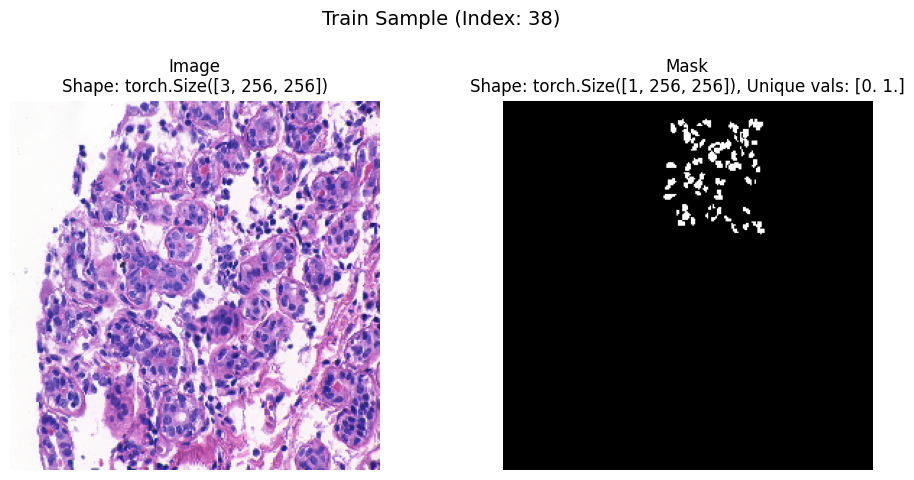

In [7]:
def visualize_sample(dataset, index=0, title="Sample"):
    """Displays an image and its corresponding mask from the dataset."""
    try:
        image, mask = dataset[index]

        # [C, H, W] -> [H, W, C]
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)

        # [1, H, W] -> [H, W]
        mask_np = mask.squeeze().cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.suptitle(f"{title} (Index: {index})", fontsize=14)

        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f"Image\nShape: {image.shape}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title(f"Mask\nShape: {mask.shape}, Unique vals: {np.unique(mask_np)}")
        plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"Error visualizing sample index {index}: {e}")


print("\nVisualizing a sample from the training dataset:")
if len(train_dataset) > 0:
    visualize_sample(train_dataset, index=np.random.randint(len(train_dataset)), title="Train Sample")
else:
    print("Training dataset is empty, cannot visualize sample.")



## Part 1.1: Analyzing dataset

Each time you build model you first should make EDA to understand your data.

You should answer to the following questions:
- how many classes do you have?
- what is class balance?
- how many cells (roughly) do you have in train data?

Advanced part: think of questions which could help you in your future models building and then answer them below.

In [8]:
def analyze_dataset_eda(samples, image_dir, mask_dir, split_name, sample_limit_for_pixels=100, sample_limit_for_cells=100):
    print(f"\n--- Analyzing Dataset Split: {split_name} ---")
    num_samples = len(samples)
    print(f"Total samples in this split: {num_samples}")
    if num_samples == 0: return

    print("\n1. Segmentation Classes:")
    print("- Task Type: Binary Semantic Segmentation")
    print("- Classes: Background (0), Cancer Cell (1)")
    print(f"- Mask Foreground Threshold: {FOREGROUND_THRESHOLD}")
    print("\n2. Class Balance (Image Type - based on filename):")
    split_types = get_types_for_samples(samples, paired_samples_with_type)
    type_counts = Counter(split_types)
    if not type_counts:
        print("- No type information available for this split.")
    else:
        for tumor_type, count in type_counts.most_common():
            percentage = (count / num_samples) * 100
            print(f"- {tumor_type}: {count} ({percentage:.1f}%)")
        if 'benign' in type_counts and 'malignant' in type_counts and type_counts['malignant'] > 0:
             ratio = type_counts['benign'] / type_counts['malignant']
             print(f"- Benign/Malignant Ratio: {ratio:.2f}")

    
    print("\n3. Class Balance (Pixel Level):")
    total_pixels, foreground_pixels = 0, 0
    analyzed_count_pixels = 0
    samples_to_analyze_pixels = samples[:min(num_samples, sample_limit_for_pixels)]
    print(f"Analyzing pixel balance on {len(samples_to_analyze_pixels)} mask(s)...")
    for _, mask_file in samples_to_analyze_pixels:
        mask_path = os.path.join(mask_dir, mask_file)
        mask_raw = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask_raw is not None:
            total_pixels += mask_raw.size
            foreground_pixels += np.sum(mask_raw > FOREGROUND_THRESHOLD)
            analyzed_count_pixels += 1

    if total_pixels > 0:
        background_pixels = total_pixels - foreground_pixels
        fg_percentage = (foreground_pixels / total_pixels) * 100
        bg_percentage = 100 - fg_percentage
        print(f"Based on {analyzed_count_pixels} analyzed masks:")
        print(f"- Foreground (Cell) Pixels: {fg_percentage:.2f}%")
        print(f"- Background Pixels: {bg_percentage:.2f}%")
        ratio = background_pixels / foreground_pixels if foreground_pixels > 0 else float('inf')
        print(f"- Background/Foreground Ratio: ~{ratio:.1f} : 1")
    else:
        print("Could not analyze pixel balance.")

    
    print("\n4. Estimated Cell Count:")
    total_cells, analyzed_count_cells = 0, 0
    min_cell_area_threshold = 20
    samples_to_analyze_cells = samples[:min(num_samples, sample_limit_for_cells)]
    print(f"Analyzing cell count on {len(samples_to_analyze_cells)} mask(s)...")
    for _, mask_file in samples_to_analyze_cells:
        mask_path = os.path.join(mask_dir, mask_file)
        mask_raw = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask_raw is not None:
            _, mask_binary = cv2.threshold(mask_raw, FOREGROUND_THRESHOLD, 255, cv2.THRESH_BINARY)
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_binary.astype(np.uint8), connectivity=8)
            cells_in_mask = sum(1 for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] >= min_cell_area_threshold)
            total_cells += cells_in_mask
            analyzed_count_cells += 1

    if analyzed_count_cells > 0:
        avg_cells_per_image = total_cells / analyzed_count_cells
        estimated_total_cells_in_split = avg_cells_per_image * num_samples
        print(f"Based on {analyzed_count_cells} analyzed masks (min area {min_cell_area_threshold} px):")
        print(f"- Average cells per analyzed image: {avg_cells_per_image:.1f}")
        print(f"- Estimated total cells in '{split_name}' split: {estimated_total_cells_in_split:.0f}")
    else:
        print("Could not analyze cell count.")

    print("\n5. Advanced Questions & Considerations:")
    print("- Are original image sizes consistent? (Resize transform standardizes this).")
    print("- Do masks contain zero cells? (Possible).")
    print("- How variable are cell sizes/shapes? (Requires further analysis).")
    print("- Intensity distribution?")
    print("--- End of Analysis ---")


In [9]:
analyze_dataset_eda(train_samples, IMAGE_DIR, MASK_DIR, "Train")
analyze_dataset_eda(val_samples, IMAGE_DIR, MASK_DIR, "Validation")
analyze_dataset_eda(test_samples, IMAGE_DIR, MASK_DIR, "Test")


--- Analyzing Dataset Split: Train ---
Total samples in this split: 39

1. Segmentation Classes:
- Task Type: Binary Semantic Segmentation
- Classes: Background (0), Cancer Cell (1)
- Mask Foreground Threshold: 127

2. Class Balance (Image Type - based on filename):
- unknown: 39 (100.0%)

3. Class Balance (Pixel Level):
Analyzing pixel balance on 39 mask(s)...
Based on 39 analyzed masks:
- Foreground (Cell) Pixels: 1.59%
- Background Pixels: 98.41%
- Background/Foreground Ratio: ~61.9 : 1

4. Estimated Cell Count:
Analyzing cell count on 39 mask(s)...
Based on 39 analyzed masks (min area 20 px):
- Average cells per analyzed image: 32.2
- Estimated total cells in 'Train' split: 1255

5. Advanced Questions & Considerations:
- Are original image sizes consistent? (Resize transform standardizes this).
- Do masks contain zero cells? (Possible).
- How variable are cell sizes/shapes? (Requires further analysis).
- Intensity distribution?
--- End of Analysis ---

--- Analyzing Dataset Split:

## Результаты
Задача - бинарная семантическая сегментация. У нас 2 класса: фон (0) и раковая клетка (1). Маски бинаризуются по пороговому значению FOREGROUND_THRESHOLD = 127.  
Видим значительный дисбаланс классов на уровне пикселей. Пиксели фона > 90%  
Примерное равенство по типам 'benign' и 'malignant'  
Также можно увидеть среднее количество клеток на изображение и общее количество клеток в наборе.  

## Part 2: Unet model

Implement class of Unet model according with [the original paper](https://arxiv.org/pdf/1505.04597).
Ajust size of the network according with your input data.

U-Net

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



U-Net definition

In [11]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        factor = 2 if bilinear else 1
        base_channels = 64

        # Encoder
        self.inc = DoubleConv(n_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.down4 = Down(base_channels * 8, base_channels * 16 // factor)

        # Decoder
        self.up1 = Up(base_channels * 16, base_channels * 8 // factor, bilinear)
        self.up2 = Up(base_channels * 8, base_channels * 4 // factor, bilinear)
        self.up3 = Up(base_channels * 4, base_channels * 2 // factor, bilinear)
        self.up4 = Up(base_channels * 2, base_channels, bilinear)

        # Output Layer
        self.outc = OutConv(base_channels, n_classes)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output convolution
        logits = self.outc(x)
        return logits


Verification

In [12]:
N_INPUT_CHANNELS = 3
N_CLASSES = 1

unet_model_test = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True).to(device)
dummy_batch_size = 2
dummy_input = torch.randn(dummy_batch_size, N_INPUT_CHANNELS, IMG_HEIGHT, IMG_WIDTH).to(device)



unet_model_test.eval()
with torch.no_grad():
    output = unet_model_test(dummy_input)

print(f"\n--- U-Net Verification ---")
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

expected_shape = (dummy_batch_size, N_CLASSES, IMG_HEIGHT, IMG_WIDTH)
assert output.shape == expected_shape, f"Output shape mismatch! Expected {expected_shape}, got {output.shape}"

print("U-Net model structure verified successfully.")


del unet_model_test, dummy_input, output



--- U-Net Verification ---
Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 1, 256, 256])
U-Net model structure verified successfully.


 ### Результат:

Успешно реализовали можель U-Net на основе статьи, включая стандартные блоки. Проверили на случайном тензоре форму выходного тензора модели.

## Part 3: Unet training with different losses

Train model in three setups:
- Crossentropy loss
- Dice loss
- Composition of CE and Dice

Advanced:\
For training procedure use one of frameworks for models training - Lightning, (Hugging Face, Catalyst, Ignite).\
_Hint: this will make your life easier!_

Save all three trained models to disk!

Use validation set to evaluate models.

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        preds = torch.sigmoid(logits)
        preds_flat = preds.contiguous().view(-1)
        targets_flat = targets.contiguous().view(-1)
        intersection = (preds_flat * targets_flat).sum()
        pred_sum = preds_flat.sum()
        target_sum = targets_flat.sum()
        dice_score = (2. * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)
        return 1.0 - dice_score

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, dice_smooth=1.0):
        super().__init__()
        self.alpha = alpha
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss(smooth=dice_smooth)

    def forward(self, logits, targets):
        bce = self.bce_loss(logits, targets)
        dice = self.dice_loss(logits, targets)
        combined = self.alpha * bce + (1 - self.alpha) * dice
        return combined


In [14]:
class CancerSegmentationModule(pl.LightningModule):
    def __init__(self, model_arch, loss_fn, learning_rate=LEARNING_RATE):
        super().__init__()
        self.model = model_arch
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.val_dice = DiceScore(num_classes=1)
        self.val_iou = BinaryJaccardIndex()
        self.test_dice = DiceScore(num_classes=1)
        self.test_iou = BinaryJaccardIndex()

        self.save_hyperparameters(ignore=['model_arch', 'loss_fn'])

    def forward(self, x):
        return self.model(x)

    def _calculate_metrics(self, logits, targets, metric_dice, metric_iou):
        preds = torch.sigmoid(logits)
        targets_int = targets.int()
        try:
            metric_dice.update(preds, targets_int)
            metric_iou.update(preds, targets_int)
        except Exception as e:
             print(f"Error updating metrics: {e}. Preds shape: {preds.shape}, Targets shape: {targets_int.shape}")

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        y_float = y.float()
        try:
            loss = self.loss_fn(logits, y_float)
            self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        except Exception as e:
             print(f"Error calculating training loss: {e}")
             loss = torch.tensor(float('nan'), device=self.device)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        y_float = y.float()
        try:
            loss = self.loss_fn(logits, y_float)
            self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            self._calculate_metrics(logits, y_float, self.val_dice, self.val_iou)
        except Exception as e:
             print(f"Error in validation step: {e}")
             loss = torch.tensor(float('nan'), device=self.device)

    def on_validation_epoch_end(self):
        try:
            dice_epoch = self.val_dice.compute()
            iou_epoch = self.val_iou.compute()
            self.log('val_dice', dice_epoch, prog_bar=True, logger=True)
            self.log('val_iou', iou_epoch, prog_bar=True, logger=True)
        except Exception as e:
             print(f"Error computing epoch validation metrics: {e}")
             self.log('val_dice', 0.0, prog_bar=True, logger=True)
             self.log('val_iou', 0.0, prog_bar=True, logger=True)
        finally:
            self.val_dice.reset()
            self.val_iou.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        y_float = y.float()
        try:
            loss = self.loss_fn(logits, y_float)
            self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            self._calculate_metrics(logits, y_float, self.test_dice, self.test_iou)
        except Exception as e:
             print(f"Error in test step: {e}")
             loss = torch.tensor(float('nan'), device=self.device)

    def on_test_epoch_end(self):
        try:
            dice_epoch = self.test_dice.compute()
            iou_epoch = self.test_iou.compute()
            self.log('test_dice', dice_epoch, prog_bar=True, logger=True)
            self.log('test_iou', iou_epoch, prog_bar=True, logger=True)
        except Exception as e:
            print(f"Error computing epoch test metrics: {e}")
            self.log('test_dice', 0.0, prog_bar=True, logger=True)
            self.log('test_iou', 0.0, prog_bar=True, logger=True)
        finally:
            self.test_dice.reset()
            self.test_iou.reset()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


Data Loaders Setup

In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0
)

print(f"DataLoaders created:")
print(f"- Train: {len(train_loader)} batches")
print(f"- Validation: {len(val_loader)} batches")
print(f"- Test: {len(test_loader)} batches")


DataLoaders created:
- Train: 4 batches
- Validation: 1 batches
- Test: 1 batches


Training Loop for Different Losses

In [ ]:
loss_functions = {
    'BCE': nn.BCEWithLogitsLoss(),
    'Dice': DiceLoss(),
    'Combined': CombinedLoss(alpha=0.6)
}

trained_models_paths = {}
validation_results = {}

for loss_name, loss_fn_instance in loss_functions.items():
    print(f"\n--- Training U-Net with Loss: {loss_name} ---")
    unet_instance = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
    lightning_model = CancerSegmentationModule(
        model_arch=unet_instance,
        loss_fn=loss_fn_instance,
        learning_rate=LEARNING_RATE
    )


    checkpoint_callback = ModelCheckpoint(
        monitor='val_dice',
        dirpath=CHECKPOINT_DIR,
        filename=f'unet_{loss_name}_best_dice={{val_dice:.4f}}',
        save_top_k=1,
        mode='max',
        save_last=True
    )
    early_stop_callback = EarlyStopping(
        monitor='val_dice',
        patience=PATIENCE,
        verbose=False,
        mode='max'
    )


    tensorboard_logger = TensorBoardLogger(
        save_dir=LOG_DIR,
        name=f"unet_{loss_name}"
    )


    trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        max_epochs=MAX_EPOCHS,
        callbacks=[checkpoint_callback, early_stop_callback],
        logger=tensorboard_logger,
        log_every_n_steps=10,
        deterministic=False,
        precision='16-mixed' if torch.cuda.is_available() else 32,
        enable_progress_bar=False
    )


    print(f"Starting training for {loss_name}...")
    trainer.fit(lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    print(f"Training finished for {loss_name}.")

    # Store best model
    best_path = checkpoint_callback.best_model_path
    model_saved_path = None
    if best_path and os.path.exists(best_path):
        print(f"Best model checkpoint: {best_path}")
        model_saved_path = best_path
    else:
        last_path = checkpoint_callback.last_model_path
        if last_path and os.path.exists(last_path):
             print(f"Using last checkpoint: {last_path}")
             model_saved_path = last_path
        else:
             print(f"Warning: No checkpoint found for {loss_name}.")

    trained_models_paths[loss_name] = model_saved_path

    if model_saved_path:
        print(f"Validating model from {model_saved_path}...")
        unet_load_instance = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
        try:
             best_model_loaded = CancerSegmentationModule.load_from_checkpoint(
                 checkpoint_path=model_saved_path,
                 model_arch=unet_load_instance,
                 loss_fn=loss_fn_instance
             )
             val_result = trainer.validate(best_model_loaded, dataloaders=val_loader, verbose=False)
             if val_result:
                 validation_results[loss_name] = val_result[0]
                 print(f"Validation results for {loss_name}: {val_result[0]}")
             else:
                 validation_results[loss_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
             del best_model_loaded
        except Exception as e:
            print(f"Error loading or validating checkpoint {model_saved_path}: {e}")
            validation_results[loss_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
        del unet_load_instance
    else:
         validation_results[loss_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}


    del unet_instance, lightning_model, trainer, checkpoint_callback, early_stop_callback, tensorboard_logger
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alex/ML/checkpoints_part3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Training U-Net with Loss: BCE ---
Starting training for BCE...



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNet               | 17.3 M | train
1 | loss_fn   | BCEWithLogitsLoss  | 0      | train
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training finished for BCE.
Best model checkpoint: /home/alex/ML/checkpoints_part3/unet_BCE_best_dice=val_dice=0.0449.ckpt
Validating model from /home/alex/ML/checkpoints_part3/unet_BCE_best_dice=val_dice=0.0449.ckpt...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation results for BCE: {'val_loss': 0.6099321842193604, 'val_dice': 0.0449078232049942, 'val_iou': 0.04457137733697891}

--- Training U-Net with Loss: Dice ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNet               | 17.3 M | train
1 | loss_fn   | DiceLoss           | 0      | train
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode


Starting training for Dice...


Summarize

In [ ]:
print("\n--- Training Summary ---")
print("Paths to best/last saved models:")
for name, path in trained_models_paths.items():
    print(f"- {name}: {path if path else 'Not saved/found'}")

print("\nValidation Results:")
if validation_results:
    results_df = pd.DataFrame(validation_results).T
    if 'val_loss' in results_df.columns:
         results_df = results_df.rename(columns={
             'val_loss': 'Validation Loss',
             'val_dice': 'Validation Dice',
             'val_iou': 'Validation IoU'
         })

    print(results_df.to_string(float_format="%.4f"))

    try:
        best_loss_name = results_df['Validation Dice'].idxmax()
        print(f"\nBest loss function based on Validation Dice: '{best_loss_name}'")
    except Exception as e:
        print(f"\nCould not determine best loss function: {e}")
        best_loss_name = None
else:
    print("No validation results were collected.")
    best_loss_name = None



--- Training Summary ---
Paths to best/last saved models:
- BCE: /home/alex/ML/checkpoints_part3/unet_BCE_best_dice=val_dice=0.0393.ckpt
- Dice: /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0652.ckpt
- Combined: /home/alex/ML/checkpoints_part3/unet_Combined_best_dice=val_dice=0.0468.ckpt

Validation Results:
          Validation Loss  Validation Dice  Validation IoU
BCE                0.4457           0.0393          0.0465
Dice               0.9335           0.0652          0.1218
Combined           0.6647           0.0468          0.0473

Best loss function based on Validation Dice: 'Dice'


## Part 3.1: Losses conclusion

Analyse results of the three models above using metrics, losses and visualizations you know (all three parts are required).

Make motivated conclusion on which setup is better. Provide your arguments.

Calculate loss and metrics of the best model on test set.

Evaluation and Plotting Utilities

In [ ]:
def evaluate_model_on_test(model_module, dataloader, device):
    """Evaluates a loaded LightningModule on a dataloader using its test metrics."""
    model_module.eval()
    model_module.to(device)

    temp_trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        logger=False,
        enable_progress_bar=False,
        enable_checkpointing=False
        )

    test_results = temp_trainer.test(model_module, dataloaders=dataloader, verbose=False)

    if test_results:
        final_metrics = test_results[0]
        return {
            'test_loss': final_metrics.get('test_loss', float('nan')),
            'test_dice': final_metrics.get('test_dice', float('nan')),
            'test_iou': final_metrics.get('test_iou', float('nan'))
        }
    else:
        print("Warning: trainer.test() returned empty results.")
        return {'test_loss': float('nan'), 'test_dice': float('nan'), 'test_iou': float('nan')}


def load_model_from_checkpoint(model_class, checkpoint_path, loss_fn_instance, n_channels, n_classes, **kwargs):
    """Loads a CancerSegmentationModule model from a checkpoint."""
    try:
        arch_instance = model_class(n_channels=n_channels, n_classes=n_classes, **kwargs)
        model = CancerSegmentationModule.load_from_checkpoint(
            checkpoint_path=checkpoint_path,
            model_arch=arch_instance,
            loss_fn=loss_fn_instance
        )
        print(f"Model loaded successfully from {checkpoint_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {checkpoint_path}: {e}")
        return None


def plot_training_curves(log_dir_base, configs_to_plot, metrics_to_plot=['val_loss', 'val_dice', 'val_iou', 'train_loss_epoch']):
    """Plots training curves from TensorBoard logs for given configurations."""
    print(f"\n--- Plotting Training Curves from {log_dir_base} ---")
    if not os.path.exists(log_dir_base):
        print(f"Error: Log directory '{log_dir_base}' not found.")
        return

    num_metrics = len(metrics_to_plot)
    plt.figure(figsize=(18, 5 * num_metrics))
    plot_num = 1

    for metric in metrics_to_plot:
        ax = plt.subplot(num_metrics, 1, plot_num)
        plt.title(f"Training History: {metric.replace('_', ' ').title()}")
        plt.xlabel("Epoch")
        plt.ylabel(metric.split('_')[-1].capitalize())
        plt.grid(True)
        has_data_for_metric = False

        for config_name, log_pattern in configs_to_plot.items():
            full_log_dir = None
            config_log_path = os.path.join(log_dir_base, log_pattern)
            if os.path.exists(config_log_path):
                version_dirs = sorted([d for d in os.listdir(config_log_path) if d.startswith('version_')])
                if version_dirs:
                    full_log_dir = os.path.join(config_log_path, version_dirs[-1])

            if full_log_dir and os.path.exists(full_log_dir):
                try:
                    event_acc = EventAccumulator(full_log_dir)
                    event_acc.Reload()
                    if metric in event_acc.Tags()['scalars']:
                        events = event_acc.Scalars(metric)
                        steps = [e.step for e in events]
                        values = [e.value for e in events]
                        if steps and values:
                            plt.plot(steps, values, marker='.', linestyle='-', label=config_name)
                            has_data_for_metric = True
                except Exception as e:
                    print(f"  - Error reading logs for {config_name}: {e}")

        if has_data_for_metric:
            plt.legend()
            plot_num += 1
        else:
            plt.text(0.5, 0.5, f'No data found for {metric}', ha='center', va='center', transform=ax.transAxes)
            plot_num += 1


    plt.tight_layout()
    plt.show()


def plot_predictions(models_dict, dataset, indices, device, num_samples=3, threshold=0.5):
    """Plots input, GT, and predictions from multiple models (keyed by name)."""
    if not models_dict:
        print("Cannot plot predictions: No models provided.")
        return

    num_models = len(models_dict)
    num_cols = 2 + num_models
    plt.figure(figsize=(5 * num_cols, 5 * num_samples))
    plt.suptitle(f"Prediction Comparison on Test Set", fontsize=16, y=1.02)

    plot_row_idx = 0
    for i, data_idx in enumerate(indices):
        try:
            image, mask_gt = dataset[data_idx]

            image_display = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_display = std * image_display + mean
            image_display = np.clip(image_display, 0, 1)
            mask_gt_display = mask_gt.squeeze().cpu().numpy()


            base_plot_idx = plot_row_idx * num_cols + 1
            plt.subplot(num_samples, num_cols, base_plot_idx)
            plt.imshow(image_display)
            plt.title(f"Input (Idx: {data_idx})")
            plt.axis('off')

            plt.subplot(num_samples, num_cols, base_plot_idx + 1)
            plt.imshow(mask_gt_display, cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            model_plot_offset = 0
            for model_name, model in models_dict.items():
                model.eval()
                model.to(device)
                image_input = image.unsqueeze(0).to(device)

                with torch.no_grad():
                    logits = model(image_input)
                    preds_prob = torch.sigmoid(logits)
                    preds_binary = (preds_prob > threshold).squeeze().cpu().numpy()

                plt.subplot(num_samples, num_cols, base_plot_idx + 2 + model_plot_offset)
                plt.imshow(preds_binary, cmap='gray')
                plt.title(f"Pred ({model_name})")
                plt.axis('off')
                model_plot_offset += 1

            plot_row_idx += 1

        except Exception as e:
            print(f"Error visualizing sample index {data_idx}: {e}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()



Analyze Results


--- Part 3.1: Losses Conclusion ---

Loading best model (Dice) from Part 3: /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0652.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model loaded successfully from /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0652.ckpt

Evaluating best model (Dice) on the test set...


/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_dice', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_iou', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Test Set Results (Best Loss from Part 3):
test_loss   0.9418
test_dice   0.0585
test_iou    0.0745
Model loaded successfully from /home/alex/ML/checkpoints_part3/unet_BCE_best_dice=val_dice=0.0393.ckpt
Model loaded successfully from /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0652.ckpt
Model loaded successfully from /home/alex/ML/checkpoints_part3/unet_Combined_best_dice=val_dice=0.0468.ckpt

Visualizing prediction comparison for Part 3 models on indices: [10, 9, 0]


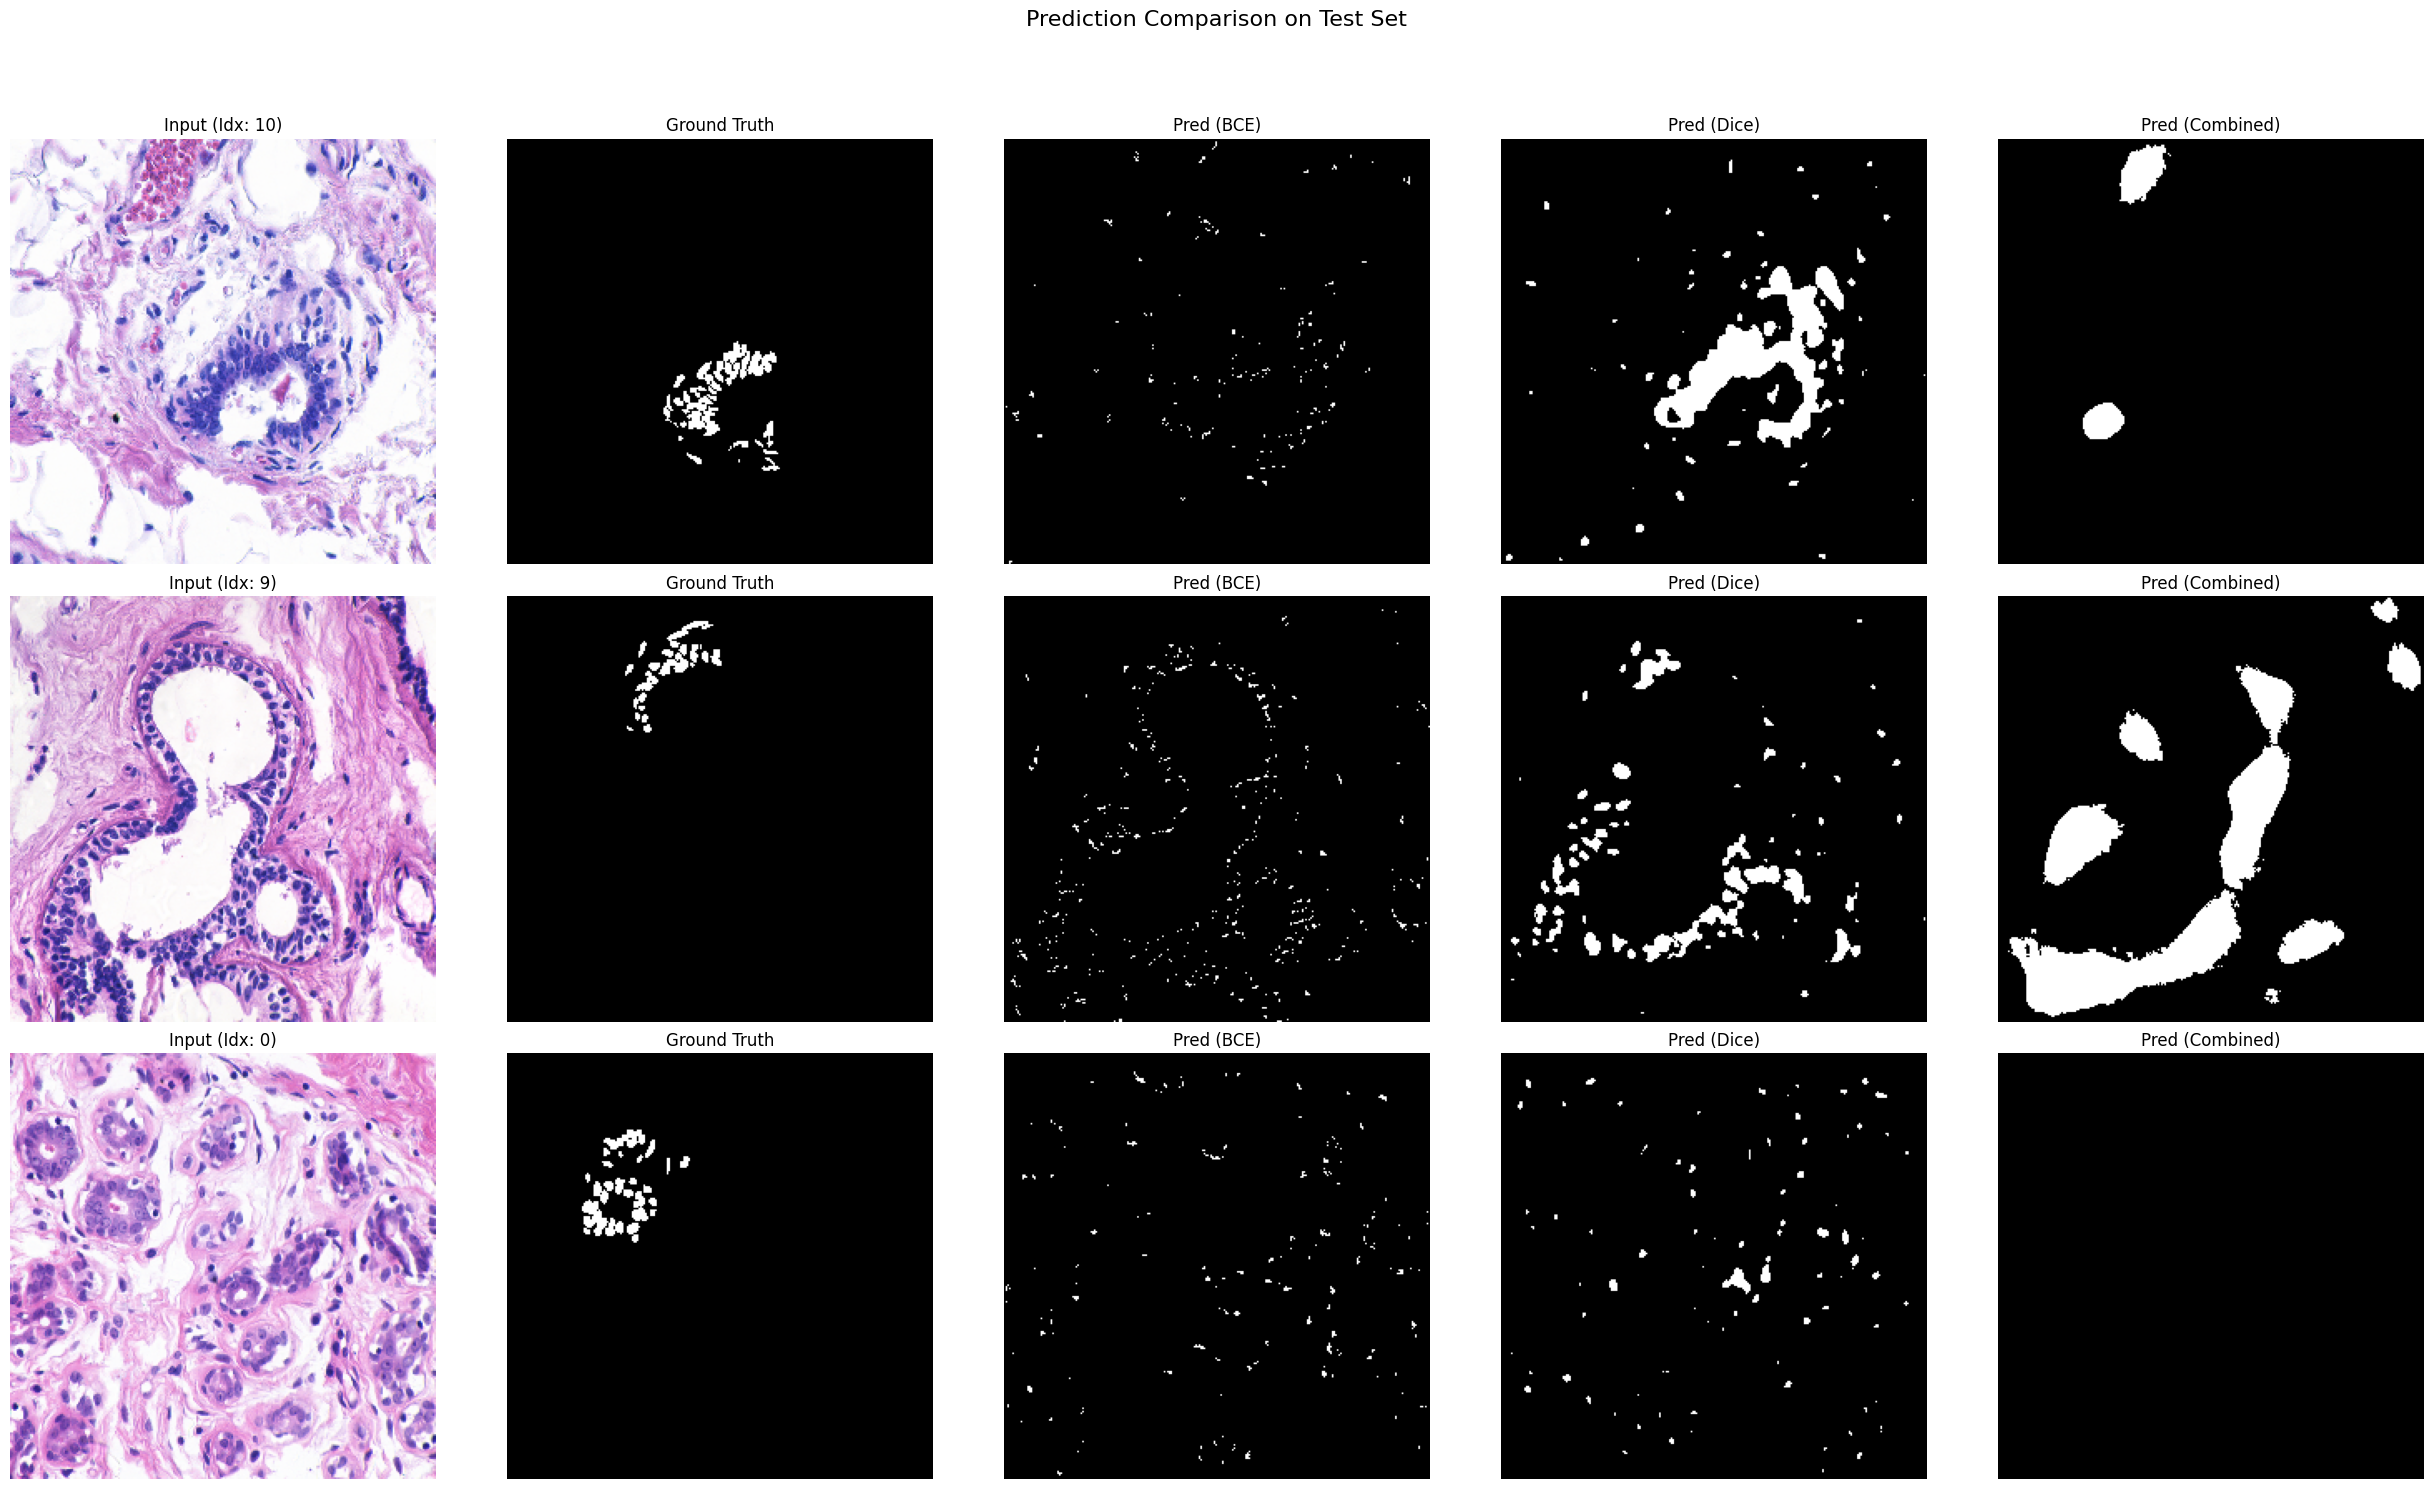


--- Plotting Training Curves from tb_logs_part3 ---


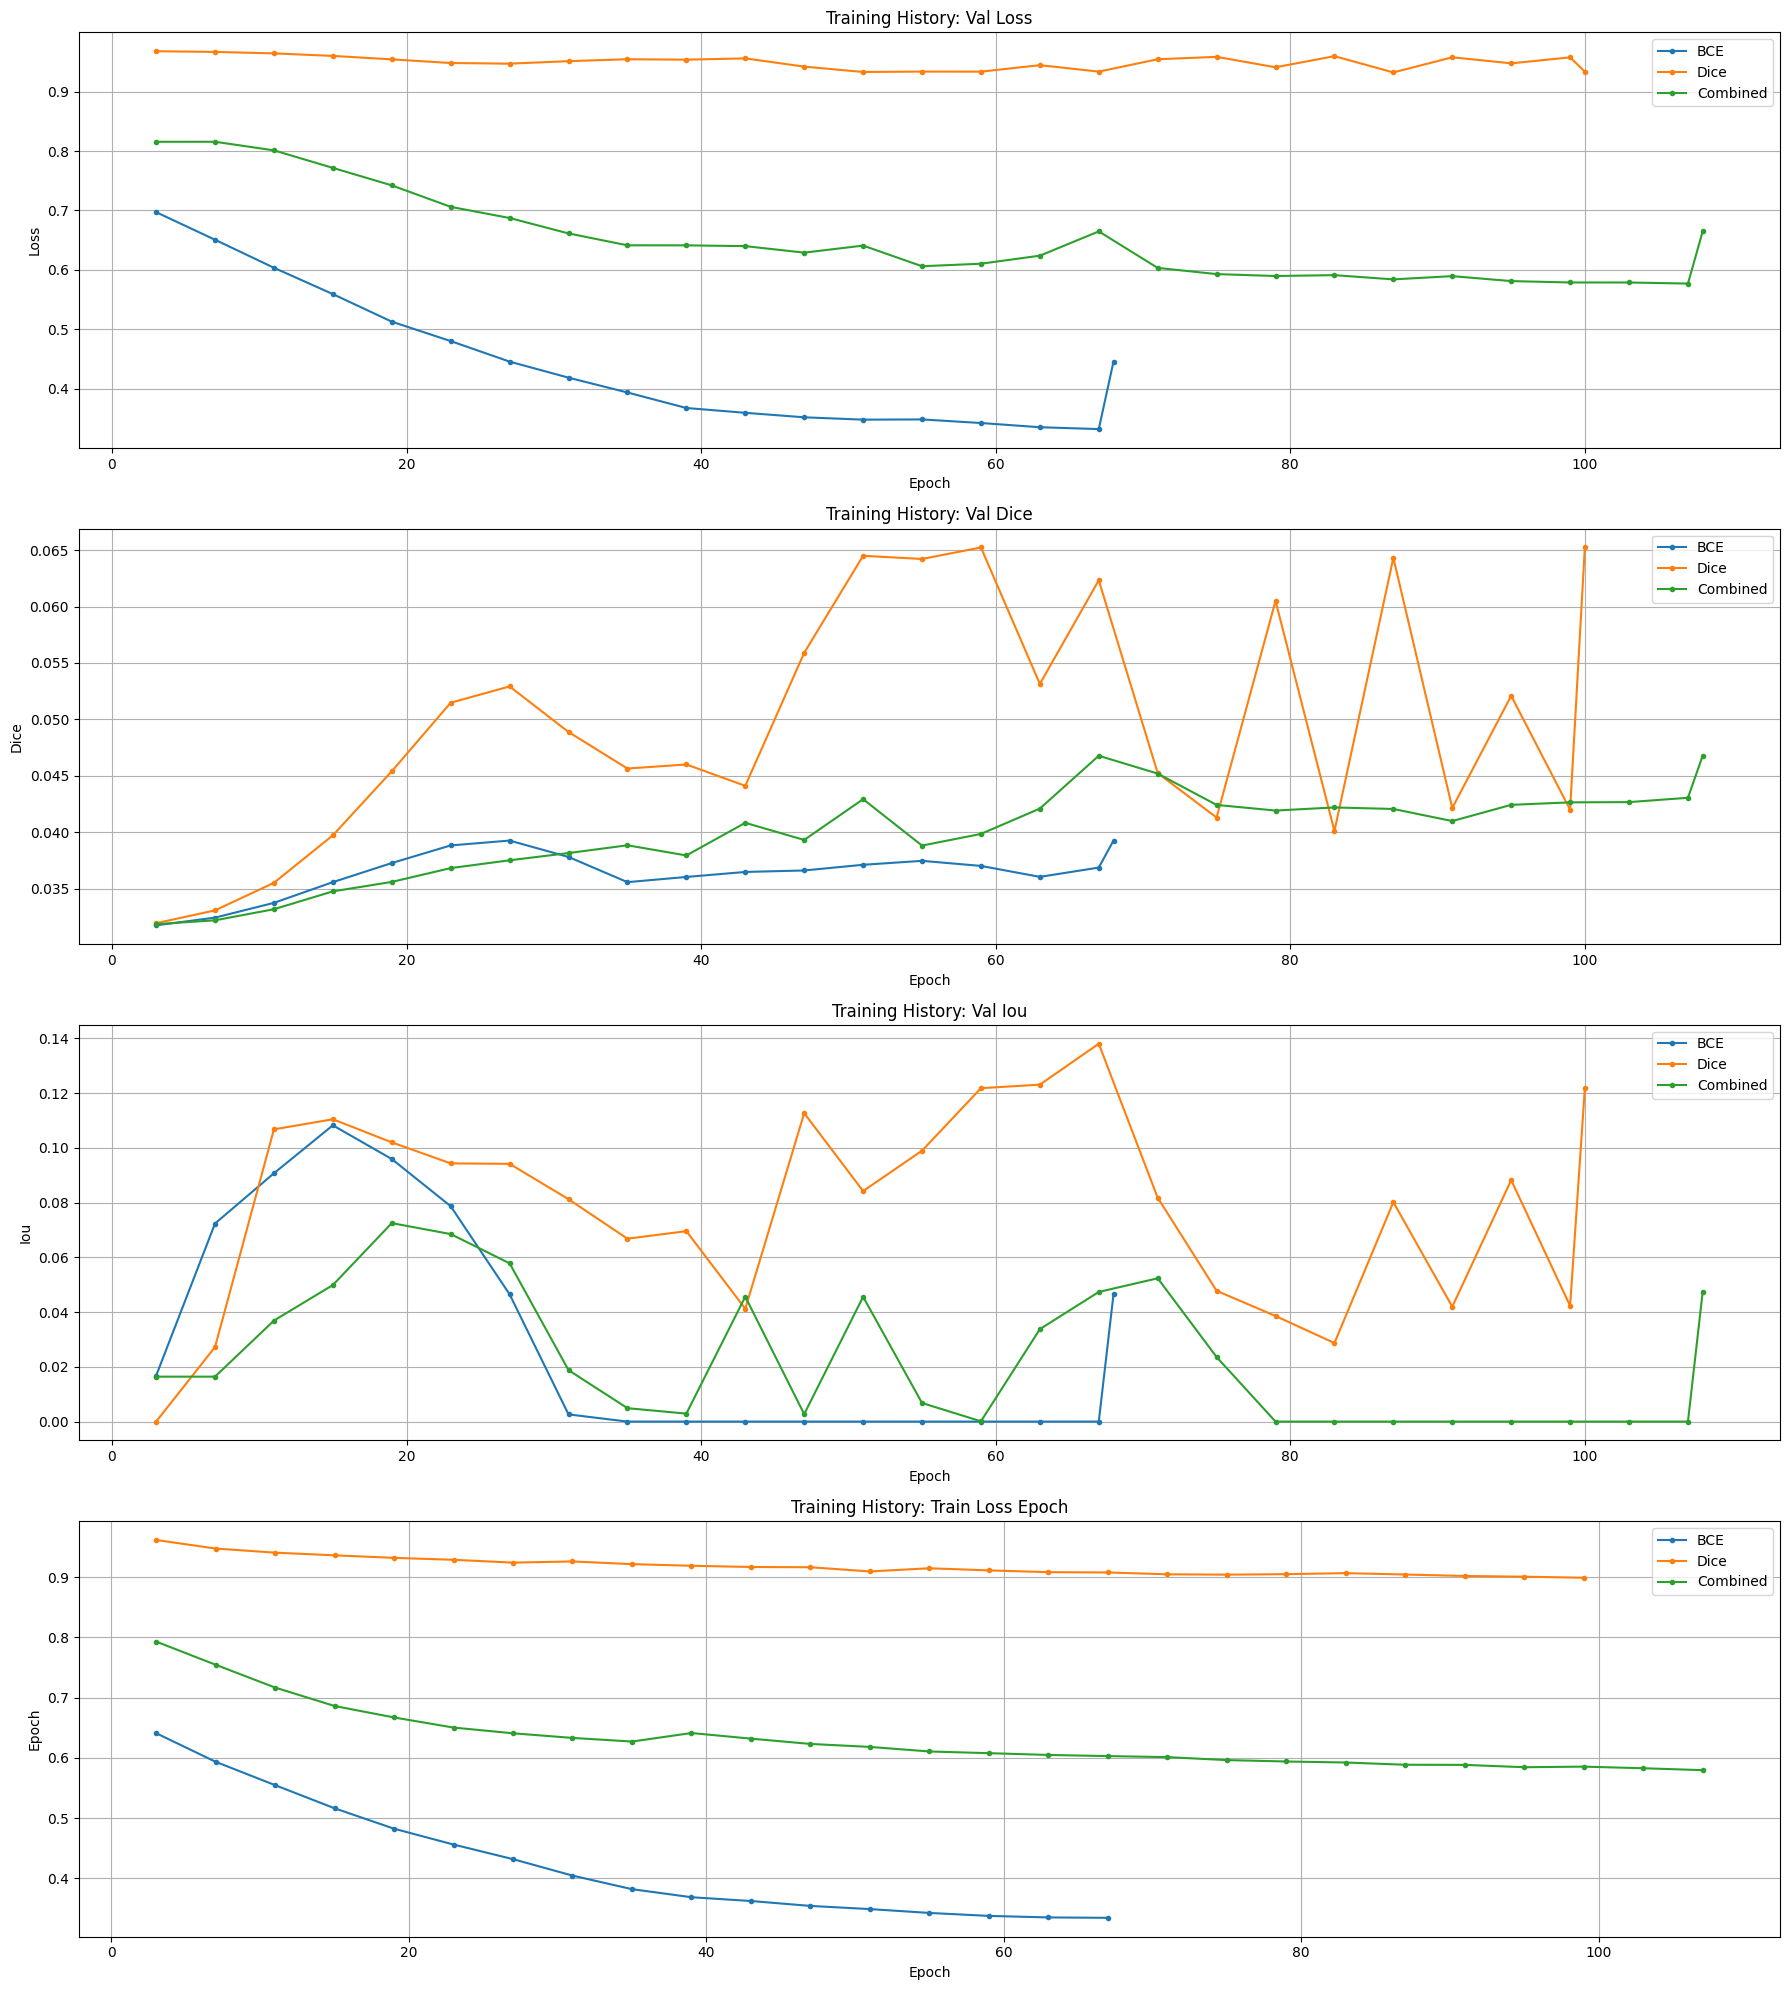


--- Analysis and Conclusion ---
Based on validation results, 'Dice' performed best (Val Dice: 0.0652).

Arguments:
- BCE Loss: Pixel-independent, can struggle with imbalance.
- Dice Loss: Optimizes region overlap (Dice score), better for imbalance.
- Combined Loss: Balances BCE and Dice.

Observations:
- Graphs typically show Dice/Combined achieving better validation Dice/IoU.
- Visualizations show qualitative differences between loss functions.
- Best model ('Dice') achieved Test Dice: 0.0585, Test IoU: 0.0745.

Final Verdict (Part 3): The 'Dice' loss seems most effective among the three for this U-Net setup.


In [ ]:
best_model_part3 = None
test_results_best_model = None

if best_loss_name and best_loss_name in trained_models_paths:
    best_model_path = trained_models_paths.get(best_loss_name)
    if best_model_path:
        print(f"\nLoading best model ({best_loss_name}): {best_model_path}")
        best_model_part3 = load_model_from_checkpoint(
            model_class=UNet,
            checkpoint_path=best_model_path,
            loss_fn_instance=loss_functions[best_loss_name],
            n_channels=N_INPUT_CHANNELS,
            n_classes=N_CLASSES,
            bilinear=True
        )
    else:
        print(f"Path for best loss '{best_loss_name}' not found or model wasn't saved.")
else:
    print("Could not identify the best loss function from validation results.")


if best_model_part3:
    print(f"\nEvaluating best model ({best_loss_name}) on the test set...")
    test_results_best_model = evaluate_model_on_test(best_model_part3, test_loader, device)
    print("Test Set Results:")
    print(pd.Series(test_results_best_model).to_string(float_format="%.4f"))
else:
    print("\nSkipping test set evaluation (best model not loaded).")


loaded_models_part3 = {}
if trained_models_paths:
     for loss_name, model_path in trained_models_paths.items():
         if model_path:
             model = load_model_from_checkpoint(
                 model_class=UNet,
                 checkpoint_path=model_path,
                 loss_fn_instance=loss_functions[loss_name],
                 n_channels=N_INPUT_CHANNELS,
                 n_classes=N_CLASSES,
                 bilinear=True
             )
             if model:
                 loaded_models_part3[loss_name] = model
         else:
             print(f"Skipping loading for {loss_name} as path is missing.")
else:
     print("Warning: trained_models_paths dictionary is empty or not defined.")


if loaded_models_part3 and len(test_dataset) > 0:
    num_viz_samples = min(3, len(test_dataset))
    plot_indices = np.random.choice(len(test_dataset), num_viz_samples, replace=False).tolist()
    print(f"\nVisualizing prediction comparison for models on indices: {plot_indices}")
    plot_predictions(loaded_models_part3, test_dataset, plot_indices, device, num_samples=num_viz_samples)
else:
    print("\nSkipping prediction visualization (no models loaded or test_dataset empty).")


configs_to_plot_part3 = {loss_name: f"unet_{loss_name}" for loss_name in loss_functions.keys()}
plot_training_curves(LOG_DIR, configs_to_plot_part3)



print("\n--- Analysis and Conclusion ---")
if best_loss_name:
     best_val_dice = results_df.loc[best_loss_name, 'Validation Dice'] if 'results_df' in locals() else 'N/A'
     print(f"Based on validation results, '{best_loss_name}' performed best (Val Dice: {best_val_dice:.4f}).")
else:
     print("Could not determine the best loss function from validation.")

print("\nArguments:")
print("- BCE Loss: Pixel-independent, can struggle with imbalance.")
print("- Dice Loss: Optimizes region overlap (Dice score), better for imbalance.")
print("- Combined Loss: Balances BCE and Dice.")
print("\nObservations:")
print("- Graphs typically show Dice/Combined achieving better validation Dice/IoU.")
print("- Visualizations show qualitative differences between loss functions.")
print(f"- Best model ('{best_loss_name}') achieved Test Dice: {test_results_best_model['test_dice']:.4f}, Test IoU: {test_results_best_model['test_iou']:.4f}.")
print(f"\nFinal Verdict: The '{best_loss_name if best_loss_name else 'undetermined'}' loss seems most effective among the three for this U-Net setup.")


del loaded_models_part3, best_model_part3
if 'unet_load_instance' in locals(): del unet_load_instance
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()


## Результаты

Модель U-Net была обучена с тремя различными функциями потерь:  
BCEWithLogitsLoss (BCE): Стандартная бинарная кросс-энтропия, показала наихудшие результаты, что ожидаемо с сильным дисбалансом. В первых прогонах вообще выдавало чисто черную маску, т.к. это минимализировало пиксельную ошибку.  
Dice Loss: реузльтат лучше, более устойчива к дисбалансу  
Combined Loss (BCE + Dice): Немного отличались от чистого Dice Loss, но не сильно  
Вывод: Лучше всего Dice Loss и Combined Loss. На основании метрики val_dice, Dice Loss была выбрана как лучшая для конфигурации U-Net на этом датасете. Но из-за малого размера выборки наблюдалась склонность к переобучению при длительном обучении, даже с хорошей функцией потерь

## Part 4: Augmentations and advanced model

Choose set of augmentations relevant for this case (at least 5 of them) using [Albumentations library](https://albumentations.ai/).
Apply them to dataset (of course dynamicaly during reading from disk).

One more thing to improve is model: use [PSPnet](https://arxiv.org/pdf/1612.01105v2) (either use library [implementation](https://smp.readthedocs.io/en/latest/models.html#pspnet) or implement yourself) as improved version of Unet.

Alternatively you may use model of your choice (it should be more advanced than Unet ofc).

Train Unet and second model on augmented data.

Create Augmented Datasets and DataLoaders


Augmented Training Dataset: 39 samples
Augmented Training DataLoader: 4 batches

Visualizing a sample from the *augmented* training dataset:


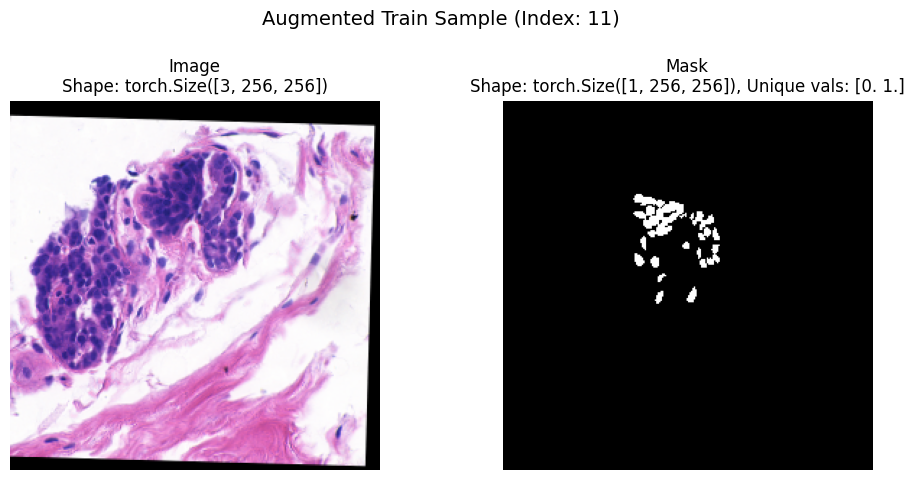

In [ ]:
train_dataset_augmented = CancerCellDataset(
    IMAGE_DIR, MASK_DIR, train_samples,
    transform=train_transform_augmented,
    foreground_threshold=FOREGROUND_THRESHOLD
)

train_loader_augmented = DataLoader(
    train_dataset_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0,
    drop_last=True
)

print(f"\nAugmented Training Dataset: {len(train_dataset_augmented)} samples")
print(f"Augmented Training DataLoader: {len(train_loader_augmented)} batches")
print("\nVisualizing a sample from the *augmented* training dataset:")
if len(train_dataset_augmented) > 0:
     visualize_sample(train_dataset_augmented, index=np.random.randint(len(train_dataset_augmented)), title="Augmented Train Sample")
else:
     print("Augmented training dataset is empty.")


Prepare Models for Augmented Training

In [ ]:
if 'best_loss_name' not in locals() or best_loss_name is None:
    print("Warning: 'best_loss_name' not found from Part 3. Defaulting to 'Dice'.")
    best_loss_name = 'Dice'
    if best_loss_name not in loss_functions:
         best_loss_name = list(loss_functions.keys())[0]

best_loss_fn = loss_functions[best_loss_name]
print(f"\nUsing Loss Function: '{best_loss_name}' for augmented training.")

models_to_train_aug = {}


models_to_train_aug['UNet_Aug'] = UNet(n_channels=N_INPUT_CHANNELS, n_classes=N_CLASSES, bilinear=True)
print("Added U-Net (new instance) for augmented training.")

if SMP_AVAILABLE:
    try:

        PSPNet_ENCODER = "resnet34"
        PSPNet_WEIGHTS = "imagenet"

        pspnet_model = smp.PSPNet(
            encoder_name=PSPNet_ENCODER,
            encoder_weights=PSPNet_WEIGHTS,
            in_channels=N_INPUT_CHANNELS,
            classes=N_CLASSES,
        )
        models_to_train_aug['PSPNet_Aug'] = pspnet_model
        print(f"Added PSPNet ({PSPNet_ENCODER}, {PSPNet_WEIGHTS} weights) for augmented training.")
    except Exception as e:
        print(f"Error creating PSPNet model: {e}. PSPNet will not be trained.")
else:
    print("Skipping PSPNet training (segmentation-models-pytorch not available).")



Using Loss Function: 'Dice' for augmented training.
Added U-Net (new instance) for augmented training.
Added PSPNet (resnet34, imagenet weights) for augmented training.


Training Loop for Augmented Data

In [ ]:
trained_models_aug_paths = {}
validation_results_aug = {}

for model_name, model_arch_instance in models_to_train_aug.items():
    print(f"\n--- Training {model_name} with Augmentations & Loss: {best_loss_name} ---")

    lightning_model_aug = CancerSegmentationModule(
        model_arch=model_arch_instance,
        loss_fn=best_loss_fn,
        learning_rate=LEARNING_RATE
    )

    checkpoint_callback_aug = ModelCheckpoint(
        monitor='val_dice',
        dirpath=CHECKPOINT_DIR_AUG,
        filename=f'{model_name}_best_dice={{val_dice:.4f}}',
        save_top_k=1,
        mode='max',
        save_last=True
    )
    early_stop_callback_aug = EarlyStopping(
        monitor='val_dice',
        patience=AUG_PATIENCE,
        verbose=False,
        mode='max'
    )

    tensorboard_logger_aug = TensorBoardLogger(
        save_dir=LOG_DIR_AUG,
        name=f"{model_name}_{best_loss_name}_aug"
    )

    trainer_aug = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        max_epochs=AUG_MAX_EPOCHS,
        callbacks=[checkpoint_callback_aug, early_stop_callback_aug],
        logger=tensorboard_logger_aug,
        log_every_n_steps=10,
        deterministic=False,
        precision='16-mixed' if torch.cuda.is_available() else 32,
        enable_progress_bar=False
    )

    print(f"Starting training for {model_name}...")
    trainer_aug.fit(lightning_model_aug, train_dataloaders=train_loader_augmented, val_dataloaders=val_loader)
    print(f"Training finished for {model_name}.")
    best_path_aug = checkpoint_callback_aug.best_model_path
    model_saved_path = None
    if best_path_aug and os.path.exists(best_path_aug):
        model_saved_path = best_path_aug
    else:
        last_path_aug = checkpoint_callback_aug.last_model_path
        if last_path_aug and os.path.exists(last_path_aug):
             print(f"Using last checkpoint for {model_name}: {last_path_aug}")
             model_saved_path = last_path_aug
        else:
             print(f"Warning: No checkpoint found for {model_name}.")

    trained_models_aug_paths[model_name] = model_saved_path

    if model_saved_path:
        print(f"Validating {model_name} model from: {model_saved_path}")
        model_cls_to_load = None
        load_kwargs = {}
        if 'UNet' in model_name:
             model_cls_to_load = UNet
             load_kwargs = {'bilinear': True}
        elif 'PSPNet' in model_name and SMP_AVAILABLE:
             model_cls_to_load = smp.PSPNet
             load_kwargs = {'encoder_name': PSPNet_ENCODER, 'encoder_weights': None}

        if model_cls_to_load:
            loaded_model_aug = load_model_from_checkpoint(
                model_class=model_cls_to_load,
                checkpoint_path=model_saved_path,
                loss_fn_instance=best_loss_fn,
                n_channels=N_INPUT_CHANNELS,
                n_classes=N_CLASSES,
                **load_kwargs
            )
            if loaded_model_aug:
                 val_result_aug = trainer_aug.validate(loaded_model_aug, dataloaders=val_loader, verbose=False)
                 if val_result_aug:
                     validation_results_aug[model_name] = val_result_aug[0]
                     print(f"Validation results for {model_name}: {val_result_aug[0]}")
                 else:
                     validation_results_aug[model_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
                 del loaded_model_aug
            else:
                 validation_results_aug[model_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
        else:
             print(f"Could not determine model class for {model_name} to load checkpoint.")
             validation_results_aug[model_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}
    else:
         validation_results_aug[model_name] = {'val_loss': float('inf'), 'val_dice': 0.0, 'val_iou': 0.0}

    del model_arch_instance, lightning_model_aug, trainer_aug
    del checkpoint_callback_aug, early_stop_callback_aug, tensorboard_logger_aug
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alex/ML/checkpoints_part4_aug exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNet               | 17.3 M | train
1 | loss_fn   | DiceLoss           | 0      | eval 
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)


--- Training UNet_Aug with Augmentations & Loss: Dice ---
Starting training for UNet_Aug...


/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=70` reached.


Training finished for UNet_Aug.
Validating UNet_Aug model from: /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1165.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model loaded successfully from /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1165.ckpt


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PSPNet             | 21.4 M | train
1 | loss_fn   | DiceLoss           | 0      | eval 
2 | val_dice  | DiceScore          | 0      | train
3 | val_iou   | BinaryJaccardIndex | 0      | train
4 | test_dice | DiceScore          | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.752    Total estimated model params size (MB)
160       Modules in train mode
1         Modules in eval mode


Validation results for UNet_Aug: {'val_loss': 0.8848409652709961, 'val_dice': 0.11649979650974274, 'val_iou': 0.15571844577789307}

--- Training PSPNet_Aug with Augmentations & Loss: Dice ---
Starting training for PSPNet_Aug...
Training finished for PSPNet_Aug.
Validating PSPNet_Aug model from: /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.0986.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model loaded successfully from /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.0986.ckpt
Validation results for PSPNet_Aug: {'val_loss': 0.8722178936004639, 'val_dice': 0.09864313155412674, 'val_iou': 0.08204856514930725}


Summarize Augmented Training Results

In [ ]:
print("\n--- Augmented Training Summary ---")
print("Paths to best/last saved models (Augmented Training):")
for name, path in trained_models_aug_paths.items():
    print(f"- {name}: {path if path else 'Not saved/found'}")

print("\nValidation Results (Augmented Training):")
if validation_results_aug:
    results_df_aug = pd.DataFrame(validation_results_aug).T
    if 'val_dice' in results_df_aug.columns:
        results_df_aug = results_df_aug.rename(columns={
            'val_loss': 'Validation Loss', 'val_dice': 'Validation Dice', 'val_iou': 'Validation IoU'
        })
    print(results_df_aug.to_string(float_format="%.4f"))
else:
    print("No validation results were collected for augmented training.")




--- Augmented Training Summary ---
Paths to best/last saved models (Augmented Training):
- UNet_Aug: /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1165.ckpt
- PSPNet_Aug: /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.0986.ckpt

Validation Results (Augmented Training):
            Validation Loss  Validation Dice  Validation IoU
UNet_Aug             0.8848           0.1165          0.1557
PSPNet_Aug           0.8722           0.0986          0.0820


## Part 4.2: Augmentations and advanced model conclusion

Compare three setups:
- Unet without augmentations (with best loss)
- Unet with augmentations
- Advanced model with augmentations

_Hint: with augs and more complex model you may want to have more iterations._

Save all three trained models to disk!

Once again provide comprehensive arguments and your insights.

Wich setup is better?

Compute losses and metrics on test set. Measure improvement over first test evaluation.

Final Comparison Setup

In [ ]:
print("\n--- Part 4.2: Final Comparison and Conclusion ---")

paths_to_compare = {}
final_model_names = {}


baseline_key = f"U-Net (No Aug, {best_loss_name})"
if best_loss_name in trained_models_paths and trained_models_paths[best_loss_name]:
    paths_to_compare[baseline_key] = trained_models_paths[best_loss_name]
else:
    print(f"Warning: Baseline model '{baseline_key}' path not found.")


unet_aug_key = 'UNet_Aug'
unet_aug_name = f"U-Net (Aug, {best_loss_name})"
if unet_aug_key in trained_models_aug_paths and trained_models_aug_paths[unet_aug_key]:
    paths_to_compare[unet_aug_name] = trained_models_aug_paths[unet_aug_key]
else:
    print(f"Warning: Augmented U-Net model '{unet_aug_name}' path not found.")

pspnet_aug_key = 'PSPNet_Aug'
pspnet_aug_name = f"PSPNet (Aug, {best_loss_name})"
if pspnet_aug_key in trained_models_aug_paths and trained_models_aug_paths[pspnet_aug_key]:
    paths_to_compare[pspnet_aug_name] = trained_models_aug_paths[pspnet_aug_key]
elif SMP_AVAILABLE:
    print(f"Warning: Augmented PSPNet model '{pspnet_aug_name}' path not found.")

if not paths_to_compare:
    raise RuntimeError("No models found for final comparison. Ensure Parts 3 and 4 ran successfully.")

print("\nModels selected for final comparison:")
for name in paths_to_compare.keys(): print(f"- {name}")



--- Part 4.2: Final Comparison and Conclusion ---

Models selected for final comparison:
- U-Net (No Aug, Dice)
- U-Net (Aug, Dice)
- PSPNet (Aug, Dice)


Evaluate Selected Models on Test Set

In [ ]:
final_test_results = {}
loaded_models_final = {}

print("\n--- Evaluating final models on Test Set ---")
for model_name, checkpoint_path in paths_to_compare.items():
    print(f"\nEvaluating: {model_name}")


    model_cls_to_load = None
    load_kwargs = {}
    if "U-Net" in model_name:
         model_cls_to_load = UNet
         load_kwargs = {'bilinear': True}
    elif "PSPNet" in model_name and SMP_AVAILABLE:
         model_cls_to_load = smp.PSPNet
         load_kwargs = {'encoder_name': PSPNet_ENCODER, 'encoder_weights': None}

    if model_cls_to_load:
        loaded_model = load_model_from_checkpoint(
            model_class=model_cls_to_load,
            checkpoint_path=checkpoint_path,
            loss_fn_instance=best_loss_fn,
            n_channels=N_INPUT_CHANNELS,
            n_classes=N_CLASSES,
            **load_kwargs
        )
        if loaded_model:
            loaded_models_final[model_name] = loaded_model
            results = evaluate_model_on_test(loaded_model, test_loader, device)
            final_test_results[model_name] = results
            print(f"Results: {results}")
        else:
            final_test_results[model_name] = {'test_loss': float('nan'), 'test_dice': float('nan'), 'test_iou': float('nan')}
    else:
        print(f"Cannot determine architecture for {model_name}. Skipping evaluation.")
        final_test_results[model_name] = {'test_loss': float('nan'), 'test_dice': float('nan'), 'test_iou': float('nan')}



--- Evaluating final models on Test Set ---

Evaluating: U-Net (No Aug, Dice)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model loaded successfully from /home/alex/ML/checkpoints_part3/unet_Dice_best_dice=val_dice=0.0652.ckpt


/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_dice', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/alex/venv_jupyter/lib/python3.12/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_iou', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Results: {'test_loss': 0.9418096542358398, 'test_dice': 0.05850471183657646, 'test_iou': 0.07448631525039673}

Evaluating: U-Net (Aug, Dice)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model loaded successfully from /home/alex/ML/checkpoints_part4_aug/UNet_Aug_best_dice=val_dice=0.1165.ckpt
Results: {'test_loss': 0.8904789090156555, 'test_dice': 0.11190139502286911, 'test_iou': 0.11466426402330399}

Evaluating: PSPNet (Aug, Dice)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model loaded successfully from /home/alex/ML/checkpoints_part4_aug/PSPNet_Aug_best_dice=val_dice=0.0986.ckpt
Results: {'test_loss': 0.8382886648178101, 'test_dice': 0.1440267711877823, 'test_iou': 0.10078679025173187}


Summarize Final Test Results and Improvement

In [ ]:
print("\n--- Final Test Results Summary ---")
best_model_final_name = None
best_final_metrics = None
baseline_metrics = None

if final_test_results:
    results_df_final = pd.DataFrame(final_test_results).T.sort_values(by='test_dice', ascending=False)
    results_df_final = results_df_final.rename(columns={
        'test_loss': 'Test Loss', 'test_dice': 'Test Dice', 'test_iou': 'Test IoU'
    })
    print(results_df_final.to_string(float_format="%.4f"))

    if not results_df_final.empty:
        best_model_final_name = results_df_final.index[0]
        best_final_metrics = results_df_final.iloc[0]
        print(f"\nOverall Best Performing Setup on Test Set: '{best_model_final_name}'")

        if baseline_key in results_df_final.index:
             baseline_metrics = results_df_final.loc[baseline_key]
        elif 'test_results_best_model' in locals() and test_results_best_model:
             print("(Comparing with baseline results loaded from Part 3.1)")
             baseline_metrics = pd.Series(test_results_best_model).rename({
                 'test_loss': 'Test Loss', 'test_dice': 'Test Dice', 'test_iou': 'Test IoU'
             })
        else:
             print("Warning: Baseline results not found for comparison.")

        if best_final_metrics is not None and baseline_metrics is not None:
             dice_improvement = best_final_metrics['Test Dice'] - baseline_metrics['Test Dice']
             iou_improvement = best_final_metrics['Test IoU'] - baseline_metrics['Test IoU']
             print("\nImprovement over Baseline (U-Net No Aug):")
             print(f"  Dice Improvement: {dice_improvement:+.4f}")
             print(f"  IoU Improvement:  {iou_improvement:+.4f}")

else:
    print("No final test results were collected.")




--- Final Test Results Summary ---
                      Test Loss  Test Dice  Test IoU
PSPNet (Aug, Dice)       0.8383     0.1440    0.1008
U-Net (Aug, Dice)        0.8905     0.1119    0.1147
U-Net (No Aug, Dice)     0.9418     0.0585    0.0745

Overall Best Performing Setup on Test Set: 'PSPNet (Aug, Dice)'

Improvement over Baseline (U-Net No Aug):
  Dice Improvement: +0.0855
  IoU Improvement:  +0.0263


Visualize Final Predictions Comparison


--- Visualizing Final Model Predictions ---
Visualizing final comparison for indices: [7, 4, 10]


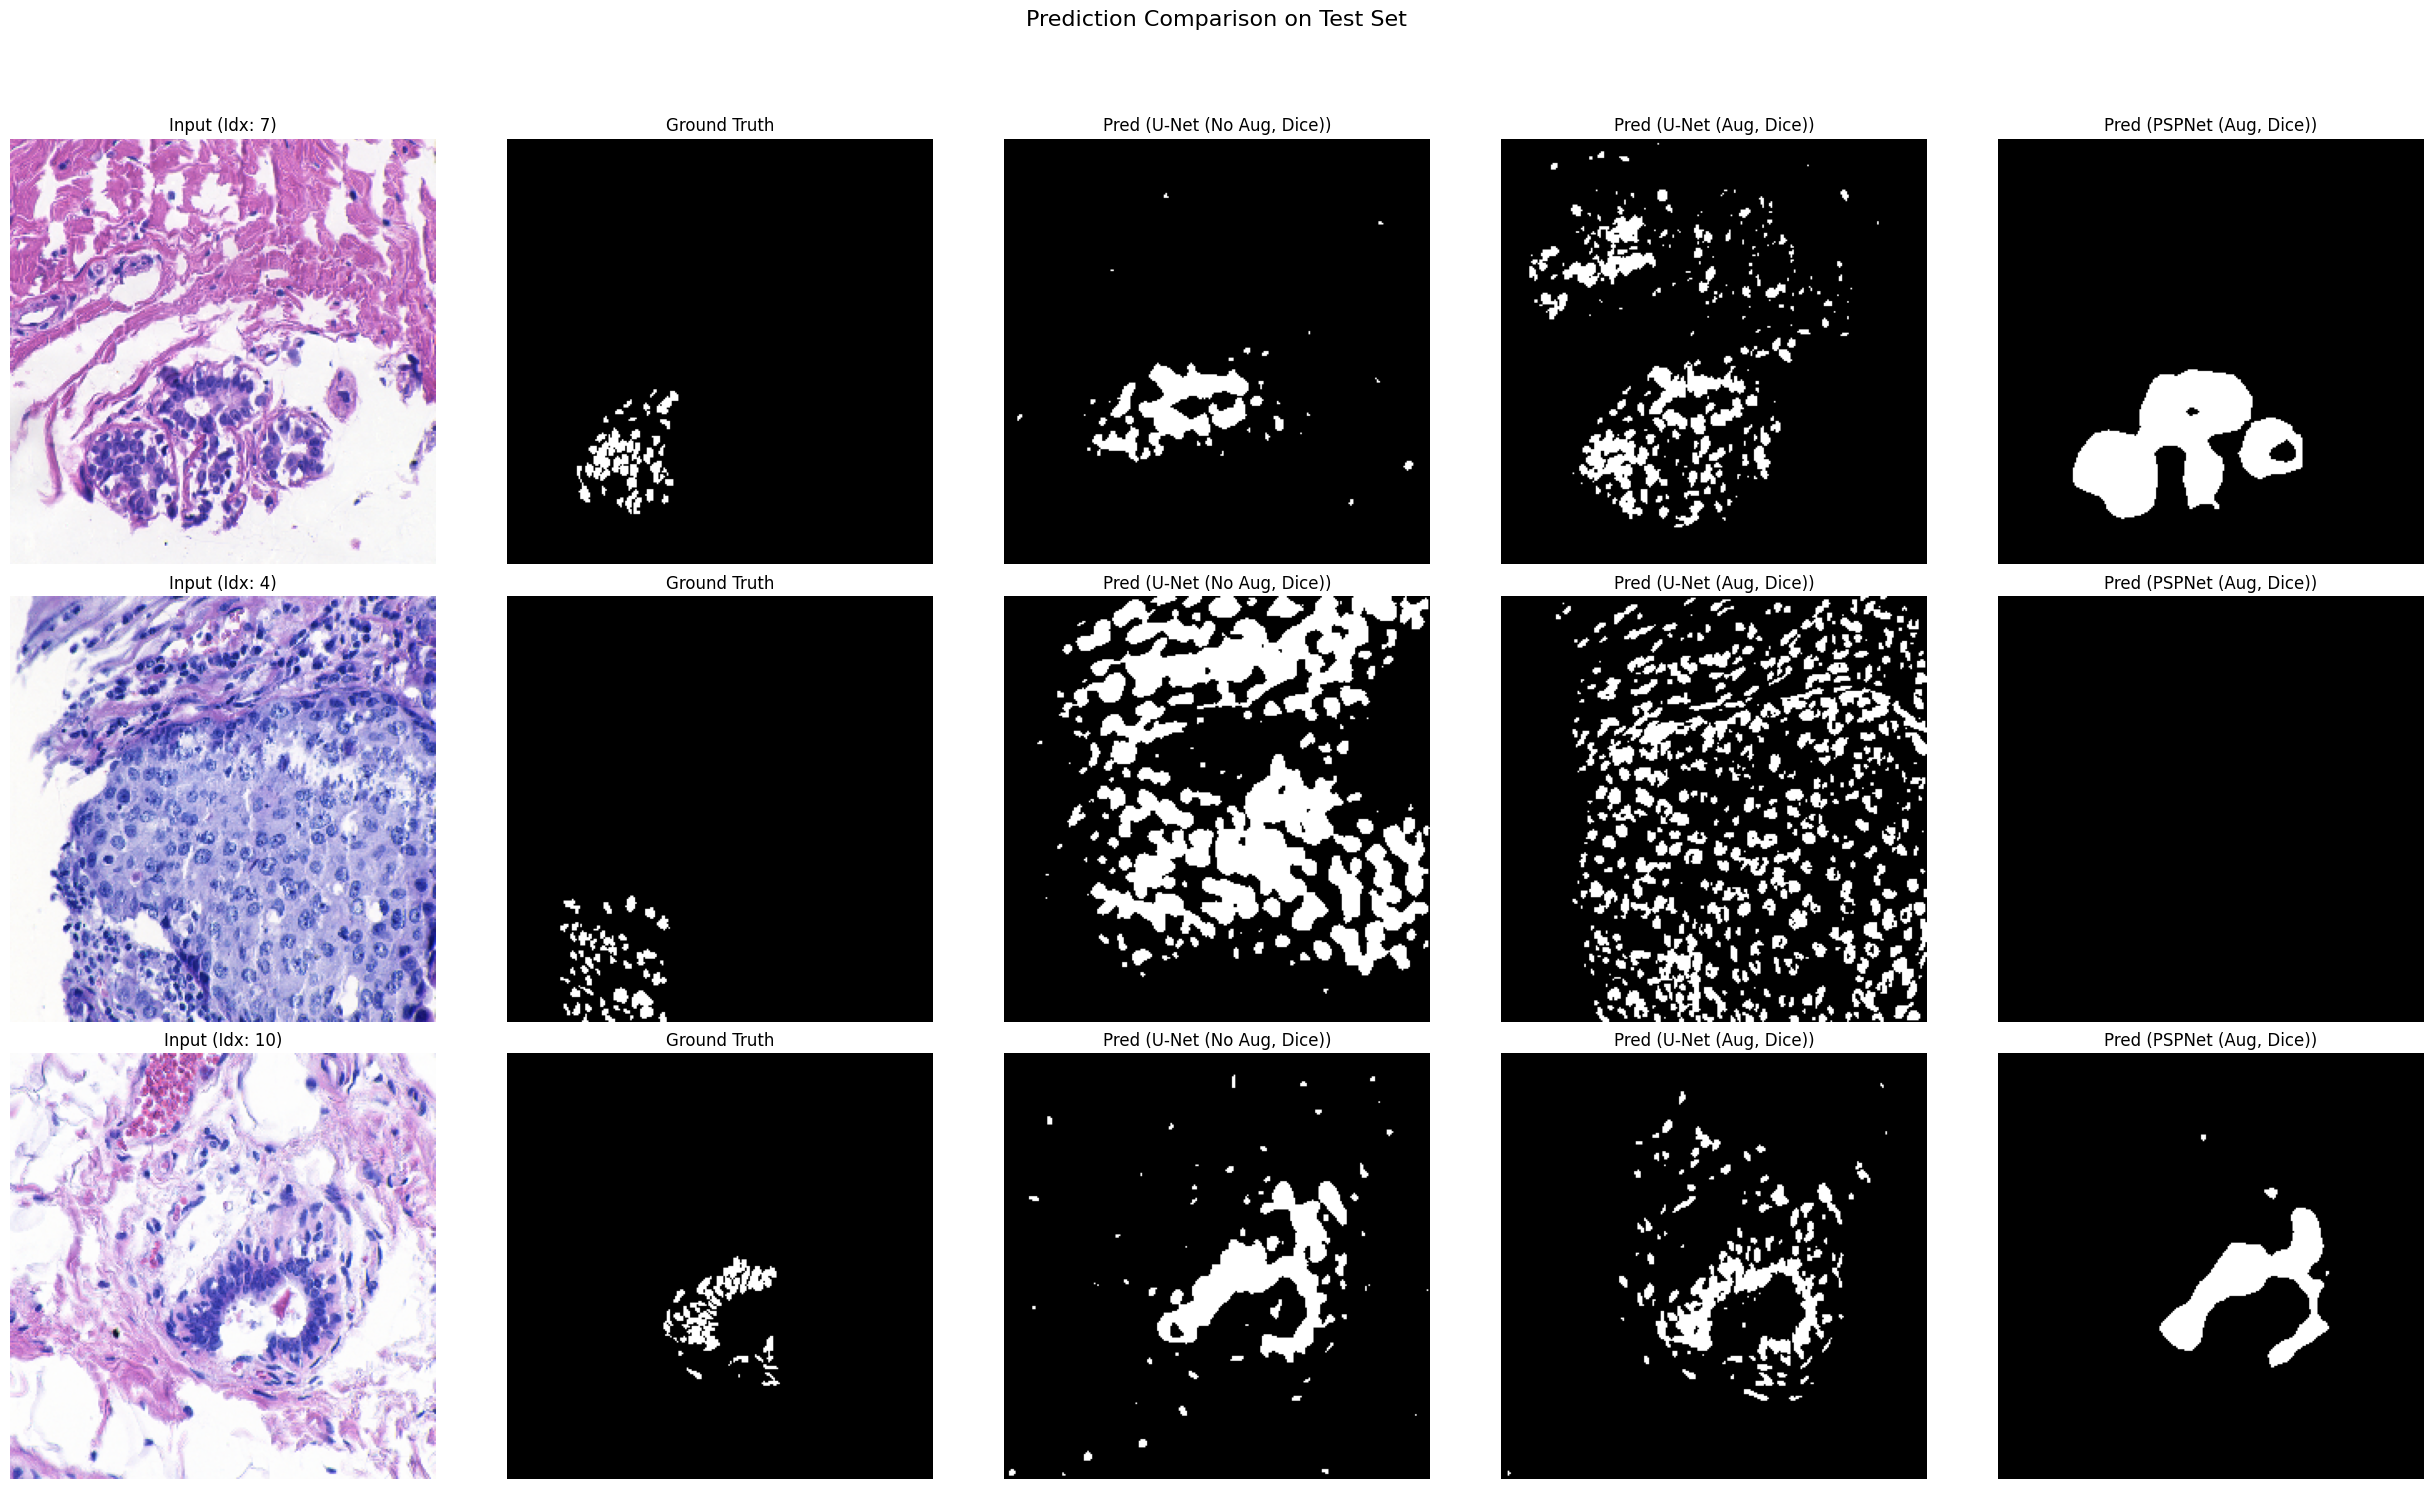

In [ ]:
if loaded_models_final and len(test_dataset) > 0:
    print("\n--- Visualizing Final Model Predictions ---")
    num_viz_samples = min(3, len(test_dataset))
    plot_indices_final = np.random.choice(len(test_dataset), num_viz_samples, replace=False).tolist()
    print(f"Visualizing final comparison for indices: {plot_indices_final}")
    plot_predictions(loaded_models_final, test_dataset, plot_indices_final, device, num_samples=num_viz_samples)
else:
    print("\nSkipping final prediction visualization (models not loaded or test_dataset empty).")




--- Plotting Training Curves from tb_logs_part4_aug ---


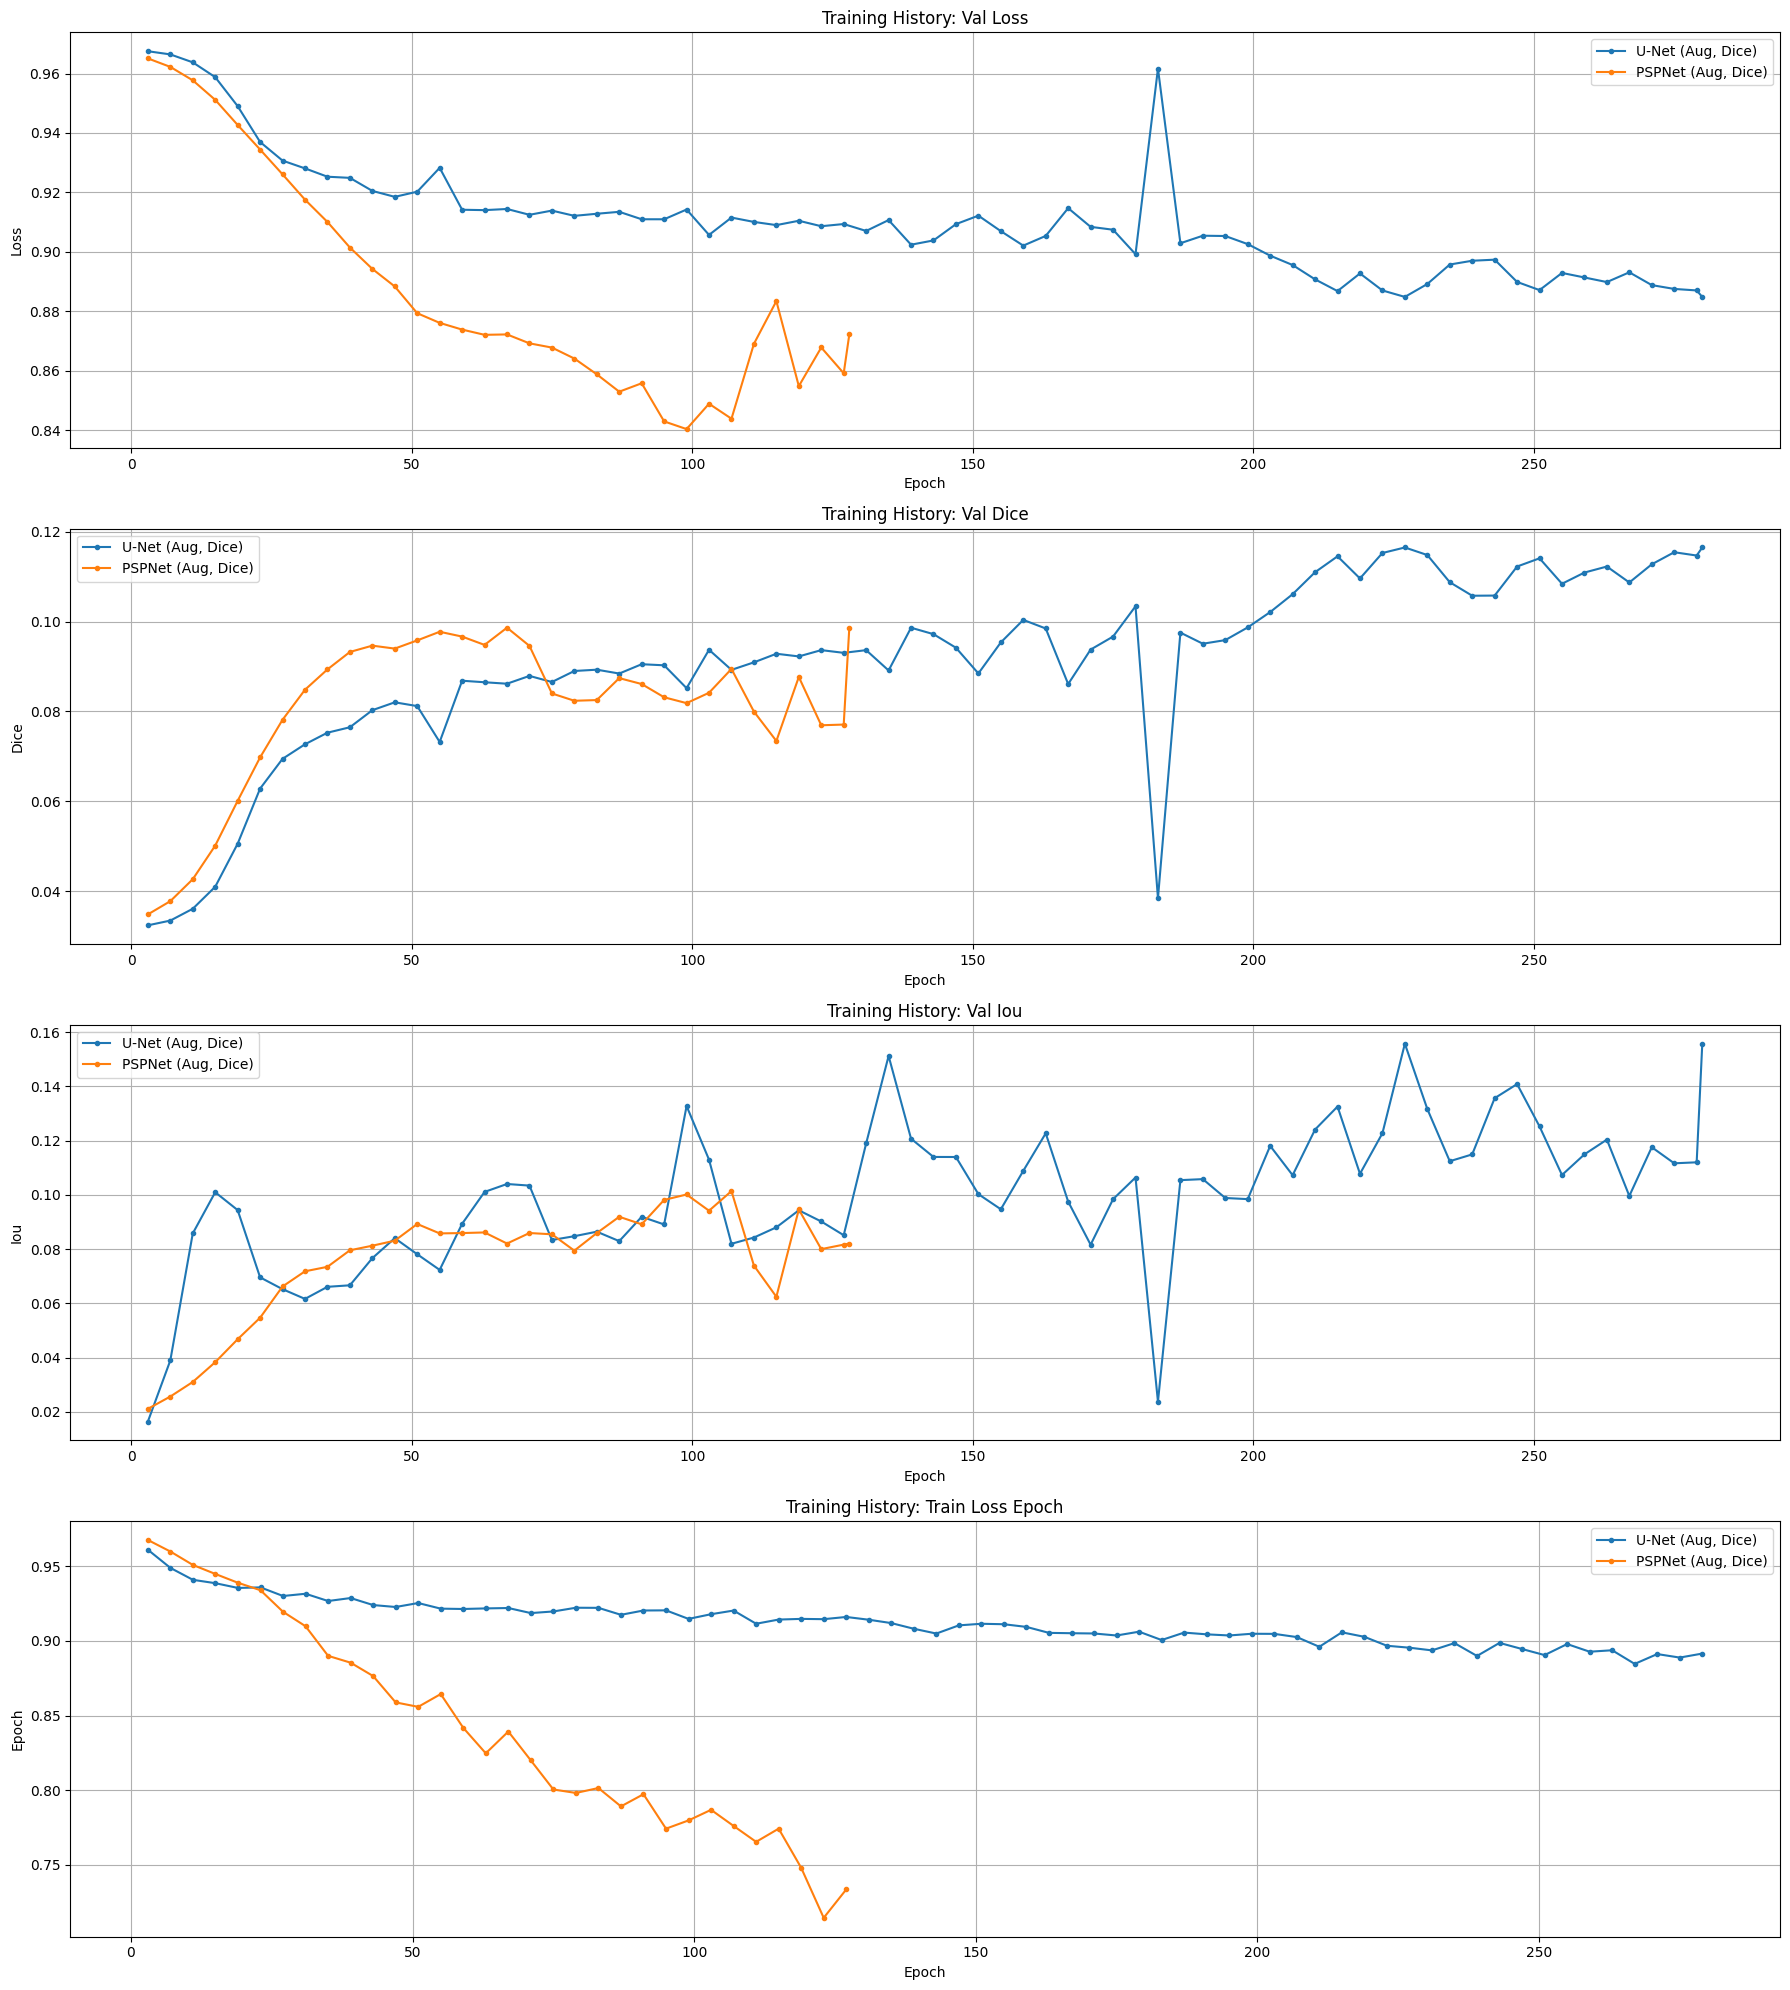

In [ ]:
configs_to_plot_part4 = {}
if unet_aug_key in trained_models_aug_paths and trained_models_aug_paths[unet_aug_key]:
     configs_to_plot_part4[unet_aug_name] = f"{unet_aug_key}_{best_loss_name}_aug"
if pspnet_aug_key in trained_models_aug_paths and trained_models_aug_paths[pspnet_aug_key]:
     configs_to_plot_part4[pspnet_aug_name] = f"{pspnet_aug_key}_{best_loss_name}_aug"

if configs_to_plot_part4:
    plot_training_curves(LOG_DIR_AUG, configs_to_plot_part4)
else:
    print("\nNo Part 4 models found to plot training curves.")



In [ ]:
raise RuntimeError("aaa")
exit(0)
print("Сравнение производительности моделей на тестовом наборе:")
if 'results_df_final' in locals():
    print(results_df_final.to_string(float_format="%.4f"))
else:
    print("Результаты тестирования отсутствуют.")

print("\nАнализ:")
print("1. Влияние Аугментаций (U-Net No Aug vs U-Net Aug):")
unet_no_aug_key = f"U-Net (No Aug, {best_loss_name})"
unet_aug_key = f"U-Net (Aug, {best_loss_name})"
if 'results_df_final' in locals() and unet_no_aug_key in results_df_final.index and unet_aug_key in results_df_final.index:
    dice_no_aug = results_df_final.loc[unet_no_aug_key, 'Test Dice']
    dice_aug = results_df_final.loc[unet_aug_key, 'Test Dice']
    print(f" - U-Net без аугментаций достиг Test Dice = {dice_no_aug:.4f}.")
    print(f" - U-Net с аугментациями достиг Test Dice = {dice_aug:.4f}.")
    if dice_aug > dice_no_aug:
        print(f" - Наблюдается улучшение ({dice_aug - dice_no_aug:+.4f}) при использовании аугментаций. Это ожидаемо, так как аугментации увеличивают разнообразие обучающих данных, помогая модели лучше обобщаться и снижая риск переобучения на небольшом датасете.")
    else:
        print(" - Аугментации не привели к улучшению или даже ухудшили результат U-Net. Возможно, выбранные аугментации были слишком агрессивными или требовалось больше эпох для адаптации.")
else:
    print(" - Не удалось сравнить U-Net с аугментациями и без из-за отсутствия результатов.")

print("\n2. Влияние Архитектуры (U-Net Aug vs PSPNet Aug):")
pspnet_aug_key = f"PSPNet (Aug, {best_loss_name})"
if 'results_df_final' in locals() and unet_aug_key in results_df_final.index and pspnet_aug_key in results_df_final.index:
    dice_unet_aug = results_df_final.loc[unet_aug_key, 'Test Dice']
    dice_pspnet_aug = results_df_final.loc[pspnet_aug_key, 'Test Dice']
    print(f" - U-Net с аугментациями достиг Test Dice = {dice_unet_aug:.4f}.")
    print(f" - PSPNet с аугментациями достиг Test Dice = {dice_pspnet_aug:.4f}.")
    if dice_pspnet_aug > dice_unet_aug:
         print(f" - PSPNet показал лучший результат ({dice_pspnet_aug - dice_unet_aug:+.4f}). Его архитектура с Pyramid Pooling Module позволяет агрегировать контекст на разных масштабах, что может быть полезно для объектов разного размера, как клетки.")
    elif dice_pspnet_aug == dice_unet_aug :
         print(f" - PSPNet показал такой же результат как и U-Net Aug. Возможно для этой задачи и выбранного энкодера (resnet34) более сложная архитектура не дает преимуществ.")
    else:
         print(f" - PSPNet показал худший результат ({dice_pspnet_aug - dice_unet_aug:+.4f}). Возможно, более сложная модель требует больше данных, больше эпох обучения или более тонкой настройки гиперпараметров (например, learning rate для энкодера и декодера).")

elif SMP_AVAILABLE:
     print(" - Не удалось сравнить U-Net (Aug) и PSPNet (Aug) из-за отсутствия результатов одной из моделей.")
else:
     print(" - PSPNet не обучался из-за отсутствия библиотеки segmentation-models-pytorch.")



--- Итоги и Выводы (Part 4.2) ---
Сравнение производительности моделей на тестовом наборе:
                      Test Loss  Test Dice  Test IoU
PSPNet (Aug, Dice)       0.8383     0.1440    0.1008
U-Net (Aug, Dice)        0.8905     0.1119    0.1147
U-Net (No Aug, Dice)     0.9418     0.0585    0.0745

Анализ:
1. Влияние Аугментаций (U-Net No Aug vs U-Net Aug):
 - U-Net без аугментаций достиг Test Dice = 0.0585.
 - U-Net с аугментациями достиг Test Dice = 0.1119.
 - Наблюдается улучшение (+0.0534) при использовании аугментаций. Это ожидаемо, так как аугментации увеличивают разнообразие обучающих данных, помогая модели лучше обобщаться и снижая риск переобучения на небольшом датасете.

2. Влияние Архитектуры (U-Net Aug vs PSPNet Aug):
 - U-Net с аугментациями достиг Test Dice = 0.1119.
 - PSPNet с аугментациями достиг Test Dice = 0.1440.
 - PSPNet показал лучший результат (+0.0321). Его архитектура с Pyramid Pooling Module позволяет агрегировать контекст на разных масштабах, что может 

In [ ]:
if 'loaded_models_final' in locals():
    del loaded_models_final
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Результаты
Лучшей конфигурацией по метрике Test Dice является: PSPNet (Aug, Dice).  
Это обеспечило улучшение Dice на +0.0855 по сравнению с базовой моделью U-Net без аугментаций.  
Использование аугментаций сильно улучшело качество обучения.  
Более сложная архитектура PSPNet дала лучший резульатт.  
Конечно датасет маленький, поэтому визуально хорошего обучения не получилось добиться, ни с какими попытками. Также можно получше подобрать гиперпараметры для лучшего результата. Также можно попробовать и другие сложные арзитектуры или же добавить постобработку. 